# Project 1: End-to-End Pipeline to Classify News Articles

## Question 1

### 1.1 Overview How many rows (samples) and columns (features) are present in the dataset?

In [1]:
import pandas as pd

df = pd.read_csv('Project1-ClassificationDataset.csv')

num_rows, num_cols = df.shape

print(f"Number of rows (samples): {num_rows}")
print(f"Number of cols (features): {num_cols}")

Number of rows (samples): 3476
Number of cols (features): 8


### 1.2 Histograms

#### (a) The total number of alpha-numeric characters per data point (row) in the feature full text: i.e count on the x-axis and frequency on the y-axis

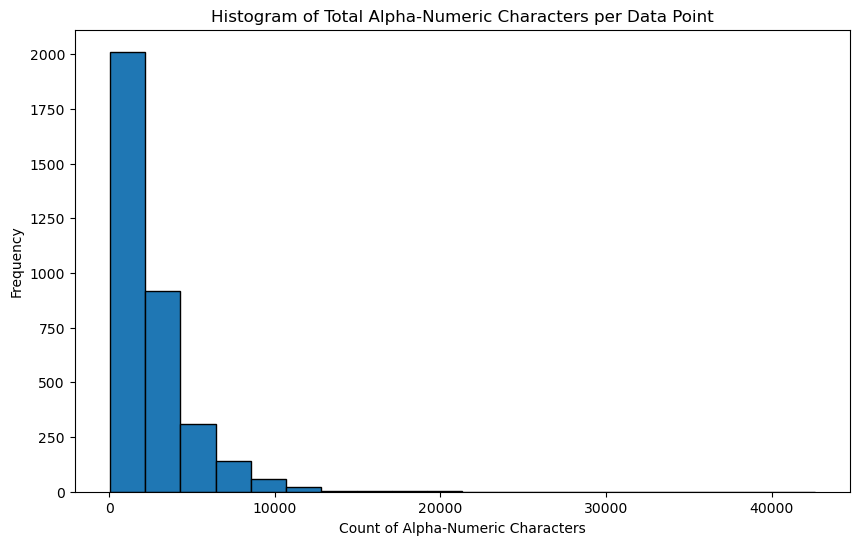

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

# Load your CSV file into a DataFrame
file_path = 'Project1-ClassificationDataset.csv'
df = pd.read_csv(file_path)

# (a) Histogram for the total number of alpha-numeric characters per data point
df['Total_AlphaNumeric_Count'] = df['full_text'].apply(lambda x: sum(c.isalnum() for c in str(x)))
plt.figure(figsize=(10, 6))
plt.hist(df['Total_AlphaNumeric_Count'], bins=20, edgecolor='black')
plt.title('Histogram of Total Alpha-Numeric Characters per Data Point')
plt.xlabel('Count of Alpha-Numeric Characters')
plt.ylabel('Frequency')
plt.show()

#### (b) The column leaf label – class on the x-axis

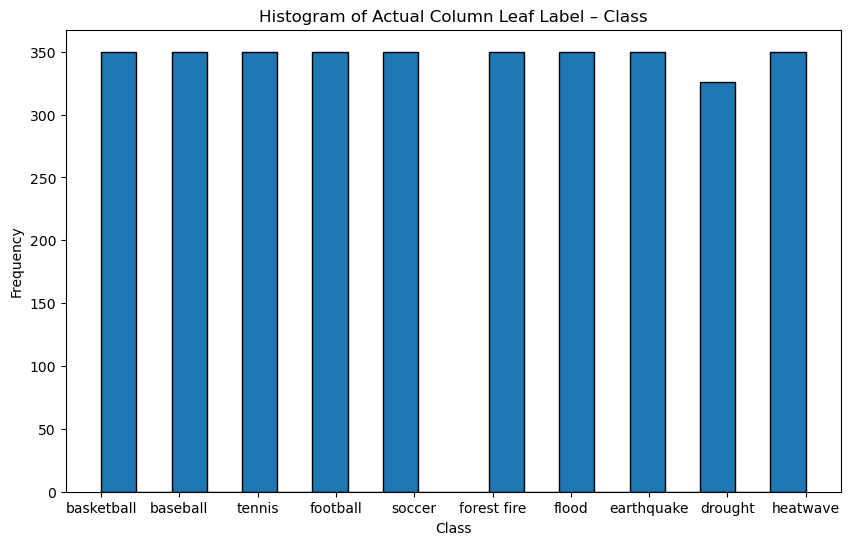

In [3]:
# (b) Histogram for the actual column leaf label – class
leaf_label_column = 'leaf_label'  
plt.figure(figsize=(10, 6))
plt.hist(df[leaf_label_column], bins=20, edgecolor='black')
plt.title('Histogram of Actual Column Leaf Label – Class')
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.show()


#### (c) The column root label – class on the x-axis.

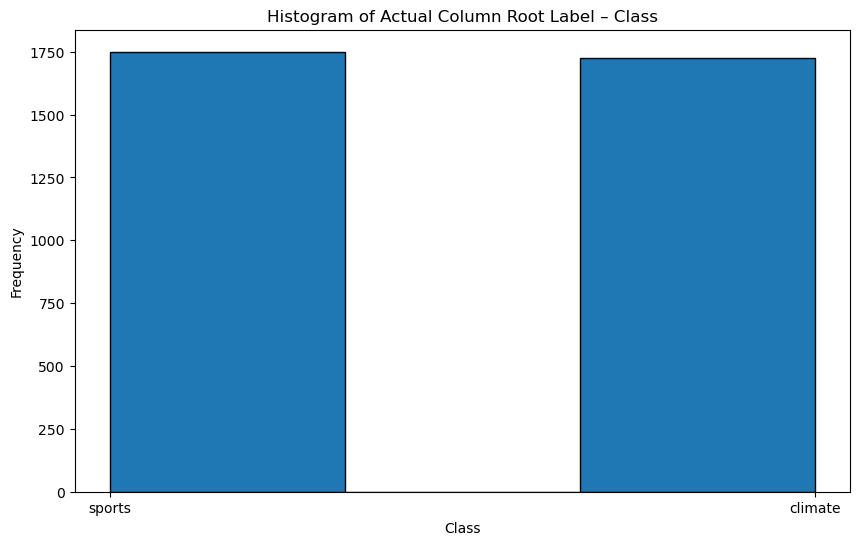

In [4]:
# (c) Histogram for the actual column root label – class
root_label_column = 'root_label'  
plt.figure(figsize=(10, 6))
plt.hist(df[root_label_column], bins=3, edgecolor='black')
plt.title('Histogram of Actual Column Root Label – Class')
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.show()

### 1.3 Interpret Plots: Provide qualitative interpretations of the histograms.

** incomplete **

(a) Histogram of Alpha Numeric Characters per Data Point
- Histogram reveals the distribution of the total number of alpha-numeric characters in the 'full_text' feature for each data point

(b) Histogram of Leaf Label Class
- They all have about the same frequency (350) except for "Drought" which has slightly less. 

(c) Histogram of Root Label Class
- Sports and Climate are approximately equally distributed (1750) with about the same frequency for each. 

## Question 2: Splitting Dataset

In [5]:
import numpy as np
import random
np.random.seed(42)
random.seed(42)

### Report the number of training and testing samples.

In [6]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(df[["full_text","root_label"]], test_size=0.2)

num_training_samples = len(train)
num_testing_samples = len(test)

print(f"Number of training samples: {num_training_samples}")
print(f"Number of testing samples: {num_testing_samples}")

Number of training samples: 2780
Number of testing samples: 696


## Question 3: Feature Extraction (Lemmatize and Vectorize)


### 3.1 Cleaning each data sample. This function helps remove many but not all HTML artefacts from the crawler’s output. 

In [7]:
import re
def clean(text):
    text = re.sub(r'^https?:\/\/.*[\r\n]*', '', text, flags=re.MULTILINE)
    texter = re.sub(r"<br />", " ", text)
    texter = re.sub(r"&quot;", "\"",texter)
    texter = re.sub('&#39;', "\"", texter)
    texter = re.sub('\n', " ", texter)
    texter = re.sub(' u '," you ", texter)
    texter = re.sub('`',"", texter)
    texter = re.sub(' +', ' ', texter)
    texter = re.sub(r"(!)\1+", r"!", texter)
    texter = re.sub(r"(\?)\1+", r"?", texter)
    texter = re.sub('&amp;', 'and', texter)
    texter = re.sub('\r', ' ',texter)
    clean = re.compile('<.*?>')
    texter = texter.encode('ascii', 'ignore').decode('ascii')
    texter = re.sub(clean, '', texter)
    if texter == "":
        texter = ""
    return texter

Call the clean(text) function to clean the crawler's output and remove most HTML artefacts 

In [8]:
train['full_text'] = train['full_text'].map(clean)
test['full_text'] = test['full_text'].map(clean)

### 3.2 Create the CountVectorizer with "english" stopword

In [9]:
from sklearn.feature_extraction.text import CountVectorizer

count_vect = CountVectorizer(min_df=3, stop_words="english")

### 3.3, 3.4, 3.5 Perform lemmatization with nltk.wordnet.WordNetLemmatizer and pos tag and Exclude terms that are numbers (e.g. “123”, “-45”, “6.7” etc.) using min_df=3

In [10]:
# Lemmatization
import nltk
from nltk import pos_tag

nltk.download()
wnl = nltk.wordnet.WordNetLemmatizer()

# Penn Trebank to wordnet 
# In the wordnet (ADJ, ADJ_SAT, ADV, NOUN, VERB = 'a', 's', 'r', 'n', 'v', POS_LIST = [NOUN, VERB, ADJ, ADV])
def penn2morphy(penntag):
    """ Converts Penn Treebank tags to WordNet. """
    morphy_tag = {'NN':'n', 'JJ':'a',
                  'VB':'v', 'RB':'r'}
    try:
        return morphy_tag[penntag[:2]]
    except:
        return 'n'

# Lemmatize entire data (data made up of sentences. Lemmatize ever word in every sentence and return the lemmatized data)
def lemmatize(data):
    lemmatized_data = [] 
    for text in data:
        # Return a tokenized copy of text 
        tokens = nltk.word_tokenize(text)
        
        # tags given list of tokens 
        tagged = pos_tag(tokens)

        # lemmatize text excluding numbers 
        lemmatized_words = []
        for word, tag in tagged:
            if not re.match(r'^\d+(\.\d+)?$', word): # Exclude terms taht are numbers 
                lemmatized_word = wnl.lemmatize(word.lower(), pos=penn2morphy(tag))
                lemmatized_words.append(lemmatized_word)
            
        lemmatized_sentence = ' '.join(lemmatized_words)
        
        # Add whole sentence back to the lemmatize_data array 
        lemmatized_data.append(lemmatized_sentence)

    return lemmatized_data

showing info https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/index.xml


In [11]:
# Lemmatize train and test datasets 
train_lemmatized = lemmatize(train['full_text'])
test_lemmatized = lemmatize(test['full_text'])

In [12]:
# Vectorize the lemmatized train and test datasets 
X_train_counts = count_vect.fit_transform(train_lemmatized)
X_test_counts = count_vect.transform(test_lemmatized)

In [13]:
from sklearn.feature_extraction.text import TfidfTransformer
# TF-IDF 
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
X_test_tfidf = tfidf_transformer.transform(X_test_counts)

print("TD-TFIDF-processed Train Matrix Shape: ", X_train_tfidf.shape)
print("TD-TFIDF-processed Test Matrix Shape: ", X_test_tfidf.shape)

TD-TFIDF-processed Train Matrix Shape:  (2780, 13754)
TD-TFIDF-processed Test Matrix Shape:  (696, 13754)


### 3.6 Answer Questions 

#### (a) What are the pros and cons of lemmatization versus stemming? How do these processes affect the dictionary size?
**Lemmatization:** 
It is a technique that involves reducing words to their root form, which is called lemma. 

Pros
1) The base/root words are actual words with meanings. So after lemmatization we do not lose the meaning of a word. 
2) In lemmatization, since we retain the meaning of the words, the accuracy is better than stemming.

Cons
1) It is slower than stemming. 
2) To implement lemmatization we need to have some linguistic understanding. 

**Stemming:** 
Stemming removes suffixes and prefixes from words, so that we can get a common representation called the stem of a word. 

Pros
1) Stemming is less computationally expensive and runs faster. Stemming is easy to implement as it does not take into account the meanings of words.
2)  Stemming helps in reducing the dictionary size. 

Cons
1) The words we obtain after stemming may not be valid words with some meaning. 
2) The acccuracy might be lesser as compared to lemmatization. 

**Dictionary size:**
Stemming gives a smaller dictionary size as it does not consider the meaning of a word, it just reduces the word by removing prefixes or suffixes. Whereas, lemmatization takes into account the meaning and results in a larger dictionary size. 

#### (b) min df means minimum document frequency. How does varying min df change the TF-IDF matrix?
The min_df parameter is used to remove the terms that are very infrequent. If min_df = 3 that means ignore the terms that appear in less than 3 documents. 


#### (c) Should I remove stopwords before or after lemmatizing? Should I remove punctuations before or after lemmatizing? Should I remove numbers before or after lemmatizing? Hint: Recall that the full sentence is input into the Lemmatizer and the lemmatizer is tagging the position of every word based on the sentence structure.
- The stopwords are removed after applying the lemmatizer. The punctuations are removed after lemmatizing, and the removing the numbers is also removed after lemmatizing.

#### (d) Report the shape of the TF-IDF-processed train and test matrices. The number of rows should match the results of Question 2. The number of columns should roughly be in the order of k×(10^3). This dimension will vary depending on your exact method of cleaning and lemmatizing and that is okay.
- The shape of the TD-IDF-processed train matrix is (2780, 13754). The shape of the TD-IDF-processed test matrix is (696, 13754). 

## Question 4: Dimensionality Reduction (LSI and NMF)

#### 4.1.1 Plot the explained variance ratio.

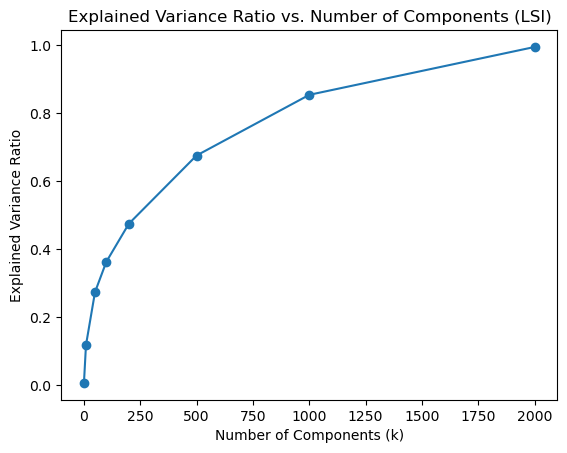

In [14]:
# NOT VALIDATED
import matplotlib.pyplot as plt
from sklearn.decomposition import TruncatedSVD

# Define values of k
k_values = [1, 10, 50, 100, 200, 500, 1000, 2000]

# Plot explained variance ratio for different values of k
explained_variances = []

for k in k_values:
    lsi = TruncatedSVD(n_components=k, random_state=0)
    lsi.fit_transform(X_train_tfidf)
    explained_variances.append(lsi.explained_variance_ratio_.sum())

plt.plot(k_values, explained_variances, marker='o')
plt.xlabel('Number of Components (k)')
plt.ylabel('Explained Variance Ratio')
plt.title('Explained Variance Ratio vs. Number of Components (LSI)')
plt.show()

#### 4.1.2 What does the explained variance ratio plot look like? 

As the number of components (k) increases, the explained variance ratio increases and converges to 1. 

#### 4.1.3 What does the plot’s concavity suggest? 

Explain Variance Ratio: Percentage of variance explained by each of the selected components.

When the plot shows that, as the number of components increases, the explained variance ratio also increases and converges to 1. With it being concave down (converging to 1), the number of components (as they increase) capture the majority of the variance in the data, and as you add more components, the increase in the ratio decreases. Converging to 1 means that most of the original data is eventually captured by the number of components tested. As you can see between k=0 to k=500, the rate at which the explaind variance ratio increases means that a lot more data is being captured within that data. Yet between k=1000 and k=2000, the rate it increases the explained variance ratio decreases. Concave down (eventually increases at a decreasing rate) means eventually it converges at that maximum. 

#### 4.2.1 Calculate the reconstruction residual MSE error. 

In [15]:
# LSI
from sklearn.decomposition import TruncatedSVD

lsi = TruncatedSVD(n_components=50, random_state=42)
X_train_lsi = lsi.fit_transform(X_train_tfidf)
X_test_lsi = lsi.transform(X_test_tfidf)

In [16]:
# NMF
from sklearn.decomposition import NMF

nmf = NMF(n_components=50, random_state=42)
X_train_NMF = nmf.fit_transform(X_train_tfidf)
X_test_NMF = nmf.transform(X_test_tfidf)

In [17]:
# LSI Reconstructed Residual MSE Error 
USigmaVt = lsi.inverse_transform(X_train_lsi)
residual_MSE_lsi = np.sum(np.array(X_train_tfidf - USigmaVt)**2)

# NMF Reconstructed Residual MSE Error 
WH = np.dot(X_train_NMF, nmf.components_)
residual_MSE_nmf = np.sum(np.array(X_train_tfidf - WH)**2)

#### 4.2.2 Which one is larger, NMF or LSI and why? 

In [18]:
if residual_MSE_lsi > residual_MSE_nmf: 
    print("LSI has a larger residual MSE error than NMF.")
elif residual_MSE_lsi < residual_MSE_nmf: 
    print("NMF has a larger residual MSE error than LSI.")
else: 
    print("NMF has the same residual MSE error as LSI.")

NMF has a larger residual MSE error than LSI.


NMF enforces non-negativity constraints which can make it less flexible than LSI (which does not enforce a non-negativity constraint). LSI is known for its ability to capture semantic relationships between words and documents. Non-negativity constraints require that the variables or parameters take values greater than or equal to zero. NMF has a higher residual MSE error because it is not as flexibile and doesn't represent the true values in its prediction as well as LSI. 

## Question 5: Classification Algorithms (Hard Margin and Soft Margin)

#### 5.1.1 Train one SVM with γ = 1000 (hard margin), another with γ = 0.0001 (soft margin).

In [19]:
from sklearn.svm import SVC

reverse_row_to_class = {'climate': 1, 'non-climate': 0}

train['r_label'] = train['root_label'].apply(lambda x: reverse_row_to_class[x] if x in reverse_row_to_class else -1)
test['r_label'] = test['root_label'].apply(lambda x: reverse_row_to_class[x] if x in reverse_row_to_class else -1)


# Binary classification labels for training set
Y_train = train['r_label']

# Binary classification labels for testing set
Y_test = test['r_label']

Hard Margin

In [20]:
# Hard Margin
hard_margin = SVC(C=1000, kernel='linear', random_state=42)

hard_margin = hard_margin.fit(X_train_lsi, Y_train)

Y_test_pred_hard = hard_margin.predict(X_test_lsi)

Soft Margin

In [21]:
# Soft Margin
soft_margin = SVC(C=0.0001, kernel='linear', random_state=42)

soft_margin = soft_margin.fit(X_train_lsi, Y_train)

Y_test_pred_soft = soft_margin.predict(X_test_lsi)

#### 5.1.2 Plot the ROC curve, report the confusion matrix and calculate the accuracy, recall, precision and F-1 score of both SVM classifiers on the testing set. 

In [22]:
# Generic Code
from sklearn.metrics import confusion_matrix 
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import auc, roc_curve
import itertools

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),horizontalalignment="center",color="white" if cm[i, j] > thresh else "black")
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

def fit_and_predict(cf, X_train, Y_train, X_test): 
    cf = cf.fit(X_train, Y_train)
    Y_pred = cf.predict(X_test)
    return Y_pred

def cf_plot(Y_test_cf, Y_pred_cf, classifier_name): 
    # # Confusion Matrix 
    class_names = ['Climate', 'Sports']
    cm = confusion_matrix(Y_test_cf, Y_pred_cf) 
    print('Confusion:\n', cm)
    plt.figure(); plot_confusion_matrix(cm, classes=class_names, title=classifier_name + ' Classifier Confusion Matrix')

def statistics(Y_test, Y_pred):
    # Statistics  
    print('Accuracy:', accuracy_score(Y_test, Y_pred))
    print('Recall:', recall_score(Y_test, Y_pred))
    print('Precision:', precision_score(Y_test, Y_pred))
    print('F-1 Score:', f1_score(Y_test, Y_pred))

In [23]:
# ROC curve
def plot_roc(fpr, tpr, classifier_name=""):
    fig, ax = plt.subplots()

    roc_auc = auc(fpr,tpr)

    ax.plot(fpr, tpr, lw=2, label= 'area under curve = %0.4f' % roc_auc)

    # Add the diagonal line
    ax.plot([0, 1], [0, 1], color='navy', linestyle='--', lw=2, label='Random Classifier')

    ax.grid(color='0.7', linestyle='--', linewidth=1)

    ax.set_xlim([-0.1, 1.1])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate',fontsize=15)
    ax.set_ylabel('True Positive Rate',fontsize=15)

    ax.legend(loc="lower right")
    ax.set_title(classifier_name + " ROC Curve", fontsize=16)

    for label in ax.get_xticklabels()+ax.get_yticklabels():
        label.set_fontsize(15)

def fit_predict_and_plot_roc(pipe, train_data, train_label, test_data, test_label, classifier_name=""):
    pipe.fit(train_data, train_label)

    if hasattr(pipe, 'decision_function'):
        prob_score = pipe.decision_function(test_data)
        fpr, tpr, _ = roc_curve(test_label, prob_score)
    else:
        prob_score = pipe.predict_proba(test_data)
        fpr, tpr, _ = roc_curve(test_label, prob_score[:,1])

    plot_roc(fpr, tpr, classifier_name)

In [24]:
def report(cf, X_train, X_test, Y_train, Y_test, classifier_name): 
    Y_pred = fit_and_predict(cf, X_train, Y_train, X_test)
    fit_predict_and_plot_roc(cf, X_train, Y_train, X_test, Y_test, classifier_name)
    cf_plot(Y_test, Y_pred, classifier_name)
    statistics(Y_test, Y_pred)

Hard Margin
Confusion:
 [[351  17]
 [  9 319]]
Accuracy: 0.9626436781609196
Recall: 0.9725609756097561
Precision: 0.9494047619047619
F-1 Score: 0.9608433734939757


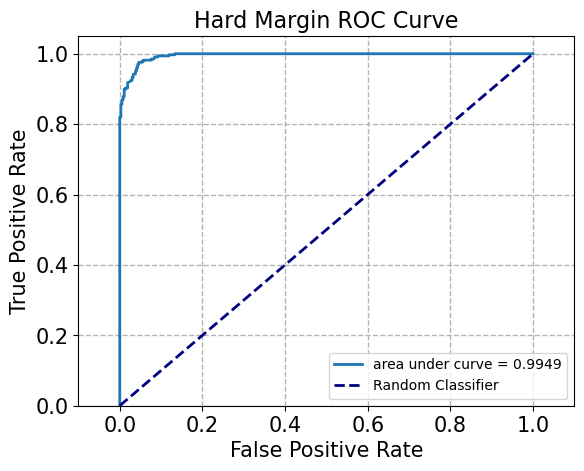

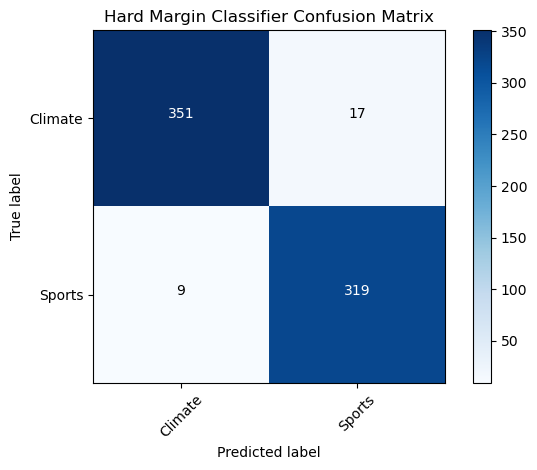

In [25]:
# Hard Margin 
print("Hard Margin")

fit_predict_and_plot_roc(hard_margin, X_train_lsi, Y_train, X_test_lsi, Y_test, "Hard Margin")
cf_plot(Y_test, Y_test_pred_hard, "Hard Margin")
statistics(Y_test, Y_test_pred_hard)

Soft Margin
Confusion:
 [[  0 368]
 [  0 328]]
Accuracy: 0.47126436781609193
Recall: 1.0
Precision: 0.47126436781609193
F-1 Score: 0.640625


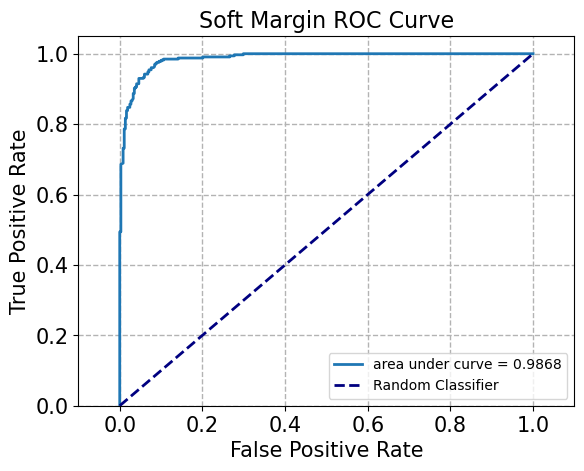

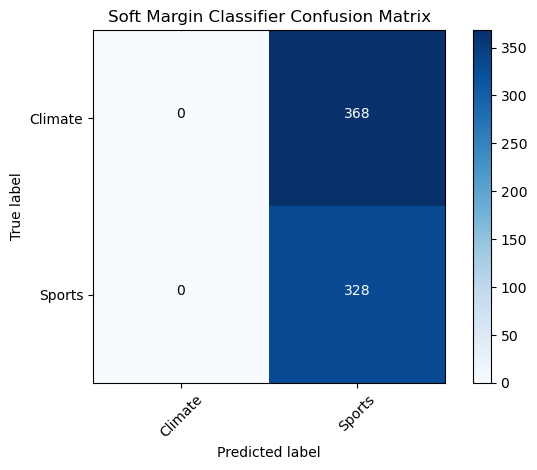

In [26]:
# Soft Margin 
print("Soft Margin")

fit_predict_and_plot_roc(soft_margin, X_train_lsi, Y_train, X_test_lsi, Y_test, "Soft Margin")
cf_plot(Y_test, Y_test_pred_soft, "Soft Margin")
statistics(Y_test, Y_test_pred_soft)

#### Which one performs better? 

Hard Margin performs better. It has a higher accuracy but for soft margin, the predicted label only matches for recreational activity most of the time but for Computer Technology, it predicts Recreational Activity instead. 

#### What about for γ = 100000?

Confusion:
 [[350  18]
 [  8 320]]
Accuracy: 0.9626436781609196
Recall: 0.975609756097561
Precision: 0.9467455621301775
F-1 Score: 0.960960960960961


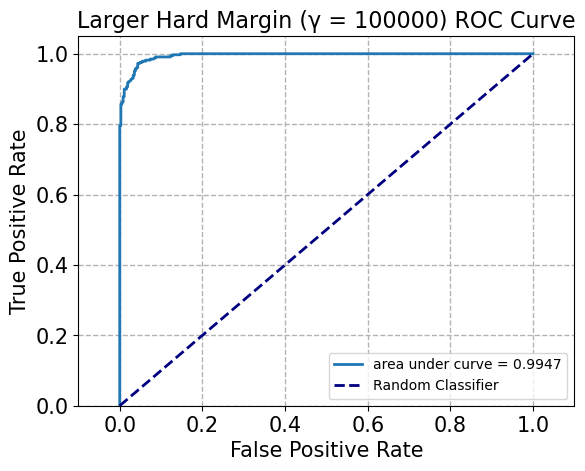

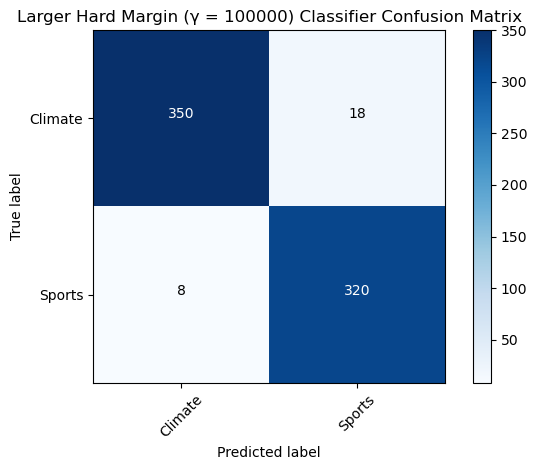

In [27]:
# γ = 100000
large_gamma = SVC(C=100000, kernel='linear', random_state=42)

report(large_gamma, X_train_lsi, X_test_lsi, Y_train, Y_test, 'Larger Hard Margin (γ = 100000)')

#### 5.1.3 What happens for the soft margin SVM? Why is the case? Analyze in terms of the confusion matrix.

Hard Margin is good for data that is perfectly separable. Since our data can be separated between Climate and Sports, it is able to do that much easier. However, with the soft margin, even if the true label is Sports, it predicts Climate 100% of the time based on the confusion matrix. Soft margin are designed to handle situations where the data is not perfectly separable. Soft margin allow for more misclassification as they incorporate outliers. 

#### 5.1.4 Does the ROC curve reflect the performance of the soft-margin SVM? Why?

The ROC curve does not reflect the performance of the soft-margin because it is a summary metric. In order to better understand the performance, we should look at the Confusion Matrix and the statistics associated. As you can see, the statistics are suboptimal: 
- Accuracy: 0.47126436781609193
- Recall: 1.0
- Precision: 0.47126436781609193
- F-1 Score: 0.640625

#### 5.2.1 Use cross-validation to choose γ (use average validation 3 accuracy to compare): Using a 5-fold cross-validation, find the best value of the parameter γ in the range {10k| − 3 ≤ k ≤ 6, k ∈ Z}. 

In [28]:
from sklearn.model_selection import cross_val_score

# Cross Validation
gamma_vals = [10**k for k in range(-3, 7)]

best_gamma = None
best_accuracy = 0

# Iterate through gamma values 
for gamma in gamma_vals:
    svc = SVC(kernel='linear', C=gamma).fit(X_train_lsi, Y_train)
    scores = cross_val_score(svc, X_train_lsi, Y_train,cv=5, scoring='accuracy')

    # Set the best gamma if it is a higher mean score  
    if (np.mean(scores) > best_accuracy):
        best_gamma = gamma
        best_accuracy = np.mean(scores)

print(best_gamma)

100


#### 5.2.2 Again, plot the ROC curve and report the confusion matrix and calculate the accuracy, recall precision and F-1 score of this best SVM.

Cross Validation
Confusion:
 [[353  15]
 [ 13 315]]
Accuracy: 0.9597701149425287
Recall: 0.9603658536585366
Precision: 0.9545454545454546
F-1 Score: 0.9574468085106382


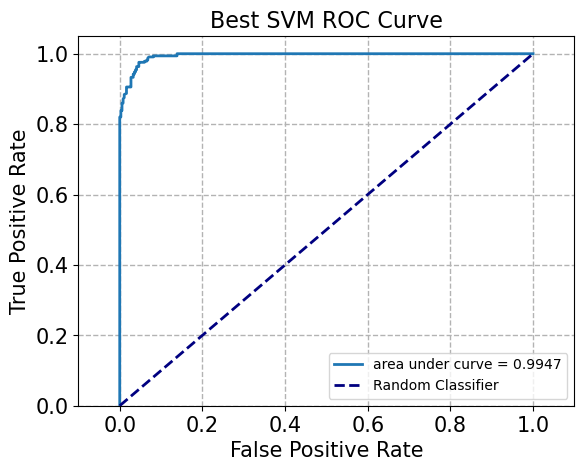

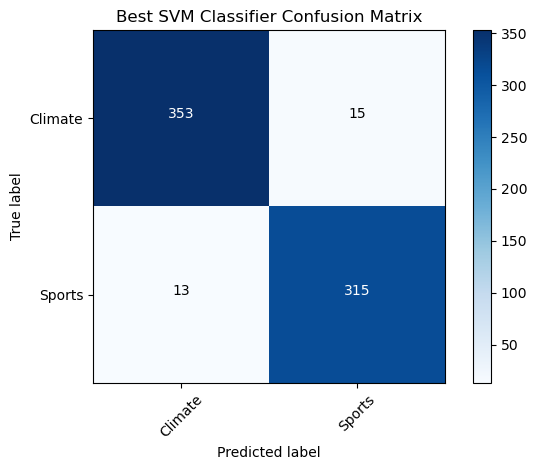

In [29]:
# Setup SVM for best SVM 
print("Cross Validation")
best_svm = SVC(kernel='linear', C=best_gamma)
report(best_svm, X_train_lsi, X_test_lsi, Y_train, Y_test, "Best SVM")

## Question 6: Logistic Classifier

#### 6.1.1 Train a logistic classifier without regularization (you may need to come up with some way to approximate this if you use sklearn.linear model.LogisticRegression)

In [30]:
from sklearn.linear_model import LogisticRegression

# Train logistic regression classifier without regularization
lr_wo_reg = LogisticRegression(C=10**10, solver='liblinear', random_state=42)
Y_test_pred_lr = fit_and_predict(lr_wo_reg, X_train_lsi, Y_train, X_test_lsi)

#### 6.1.2 Plot the ROC curve and report the confusion matrix and calculate the accuracy, recall precision and F-1score of this classifier on the testing set.

Cross Validation
Confusion:
 [[352  16]
 [ 13 315]]
Accuracy: 0.9583333333333334
Recall: 0.9603658536585366
Precision: 0.9516616314199395
F-1 Score: 0.9559939301972684


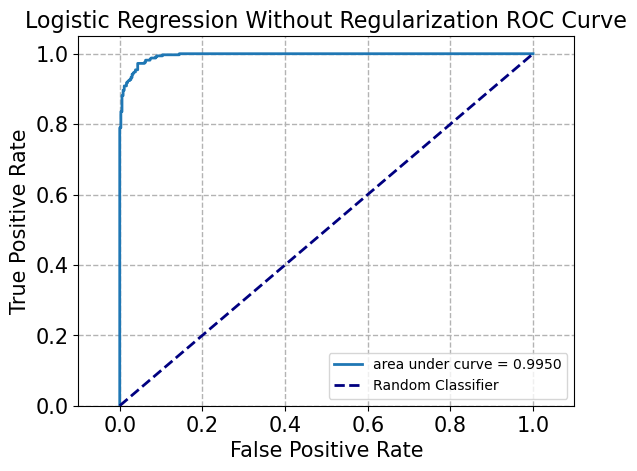

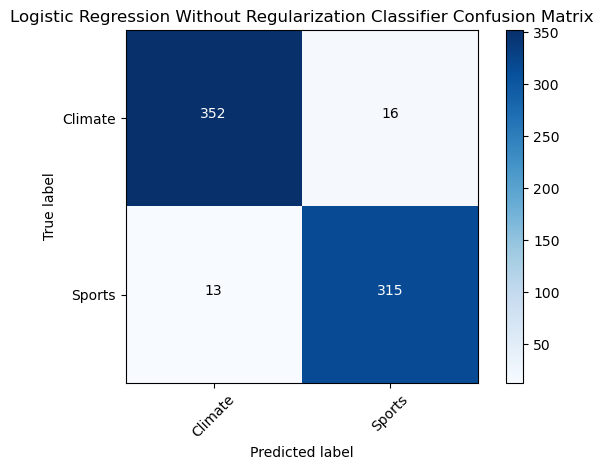

In [31]:
print("Cross Validation")

fit_predict_and_plot_roc(lr_wo_reg, X_train_lsi, Y_train, X_test_lsi, Y_test, "Logistic Regression Without Regularization")
cf_plot(Y_test, Y_test_pred_lr, "Logistic Regression Without Regularization")
statistics(Y_test, Y_test_pred_lr)

### 6.2 Find the optimal regularization coefficient

#### 6.2.1 Using 5-fold cross-validation on the dimension-reduced-by-SVD training data, find the optimal regularization strength in the range {10k|−5 ≤ k ≤ 5, k ∈ Z} for logistic regression with L1 regularization and logistic regression with L2 regularization, respectively.

In [32]:
# Finding optimal regularization strength

def opt_reg_strength(X_train, Y_train, penalty):
    reg_strength = [10**k for k in range(-5, 6)]

    best_strength = None
    best_score = 0

    # Creates a Logistic Regression for each strength level 
    for strength in reg_strength:
        lr = LogisticRegression(C=strength, penalty=penalty, solver='liblinear', random_state=42).fit(X_train, Y_train)
        scores = cross_val_score(lr, X_train, Y_train,cv=5, scoring='accuracy')

        # updates best strength given if higher mean score 
        if (np.mean(scores) > best_score):
            best_strength = strength
            best_score = np.mean(scores)

    return best_strength

In [33]:
opt_strength_lr_l1 = opt_reg_strength(X_train_lsi, Y_train, 'l1')
opt_strength_lr_l2 = opt_reg_strength(X_train_lsi, Y_train, 'l2')

print("Optimal Regularization Strength for L1: ", opt_strength_lr_l1)
print("Optimal Regularization Strength for L2: ", opt_strength_lr_l2)

Optimal Regularization Strength for L1:  10
Optimal Regularization Strength for L2:  100


#### 6.2.2 Compare the performance (accuracy, precision, recall and F-1 score) of 3 logistic classifiers: w/o regularization, w/ L1 regularization and w/ L2 regularization (with the best parameters you found from the part above), using test data.

In [34]:
# Performance of Logistic Classifier w/o regularization
lr_wo_reg = LogisticRegression(C=10**10, solver='liblinear', random_state=42)
Y_test_pred_lr = fit_and_predict(lr_wo_reg, X_train_lsi, Y_train, X_test_lsi) # added
# Statistics 
print("-"*20 + " Performance of Logistic Classifier w/o regularization "+ "-"*20)
statistics(Y_test, Y_test_pred_lr)

# Performance of Logistic Classifier w/ L1 regularization
lr_w_l1 = LogisticRegression(C=opt_strength_lr_l1, solver='liblinear', penalty='l1', random_state=42)
Y_test_pred_lr_l1 = fit_and_predict(lr_w_l1, X_train_lsi, Y_train, X_test_lsi) # added
# Statistics 
print("-"*20 + " Performance of Logistic Classifier w/ L1 regularization "+ "-"*20)
statistics(Y_test, Y_test_pred_lr_l1)

# Performance of Logistic Classifier w/ L2 regularization
lr_w_l2 = LogisticRegression(C=opt_strength_lr_l2, solver='liblinear', penalty='l2', random_state=42)
Y_test_pred_lr_l2 = fit_and_predict(lr_w_l2, X_train_lsi, Y_train, X_test_lsi) # added
# Statistics 
print("-"*20 + " Performance of Logistic Classifier w/ L2 regularization "+ "-"*20)
statistics(Y_test, Y_test_pred_lr_l2)

-------------------- Performance of Logistic Classifier w/o regularization --------------------
Accuracy: 0.9583333333333334
Recall: 0.9603658536585366
Precision: 0.9516616314199395
F-1 Score: 0.9559939301972684
-------------------- Performance of Logistic Classifier w/ L1 regularization --------------------
Accuracy: 0.9597701149425287
Recall: 0.9634146341463414
Precision: 0.9518072289156626
F-1 Score: 0.9575757575757576
-------------------- Performance of Logistic Classifier w/ L2 regularization --------------------
Accuracy: 0.9597701149425287
Recall: 0.9603658536585366
Precision: 0.9545454545454546
F-1 Score: 0.9574468085106382


#### 6.2.3 How does the regularization parameter affect the test error? How are the learnt coefficients affected? Why might one be interested in each type of regularization?

How does the regularization parameter affect the test error? 
- Without regularization: No regularization (small values of coefficients) can lead to underfitting and can be a simple model but can also lead to large coefficients. Both can have improper fitting to the data and cause high test error. 
- L1: Encourages sparsity and exclude less reelvant features. Test error could be reduced if irrelevant features are removed and making it more generic. 
- L2: Discourages large coefficients and prevent overfitting. Test error might decrease because it prevents the model from being too sensitive to noise. 

How are the learnt coefficients affected? 
- Without regularization: regularization doesn't have any set values to features, which can lead the model to assign larger values of coefficients to features to minimize training error. 
- L1: Learned coefficients can be 0 for some features, allowing it to incorporate sparsity. 
- L2: Discourages large coefficients so that it can incorporate all features. 

Why might one be interested in each type of regularization?
- Without regularization: Good for large dataset where there could be a lot of information in the features. Model with high complexity may need more flexibilty - especially when the distribution of the dataset may be unknown. 
- L1: When only a subset of the features are relevant. 
- L2: When all features are correlated, it stabalizes the coefficients for all the features. 

#### 6.2.4 Both logistic regression and linear SVM are trying to classify data points using a linear decision boundary. What is the difference between their ways to find this boundary? Why do their performances differ? Is this difference statistically significant?

What is the difference between their ways to find this boundary? 
- Logistic: Models the probabilty of the postiive class using logistic function. Parameters are learned by maximizing likelihood of hte observed labels using gradient descent. The boundary is chosen such that the predicted probabilities map to class labels.  
- Linear: It aims to find the hyperplane that separates the two classes in teh feature space. It defines the parameters by learning with the minimal cost that penalizes misclassification and encourages a larger margin. THe boundary is determiend by the hyperplane. 

Why do their performances differ? 
- Logistic: Sensitive to oultiers since it aims to maximize the likelihood of observed labels. It can influence the parameter estimates. 
- Linear: Less sensitive to outliers since it wants to maximize the margin. 

Is this difference statistically significant?
- In this dataset, the difference is not statistically significant because the data is similarly modeled with a similar level of accuracy ~96% 

## Question 7: Naive Bayes Classifier

### 7.1.1 Evaluate and profile a Naive Bayes classifier: Train a GaussianNB classifier

In [35]:
from sklearn.naive_bayes import GaussianNB

# Train Gaussian Naive Bayes classifier 
gnb_cf = GaussianNB()
Y_test_pred_gnb = fit_and_predict(gnb_cf, X_train_lsi, Y_train, X_test_lsi)

### 7.1.2 Plot the ROC curve and report the confusion matrix and calculate the accuracy, recall, precision and F-1 score of this classifier on the testing set.

Naive Bayes Classifier
Confusion:
 [[358  10]
 [ 61 267]]
Accuracy: 0.8979885057471264
Recall: 0.8140243902439024
Precision: 0.9638989169675091
F-1 Score: 0.8826446280991737


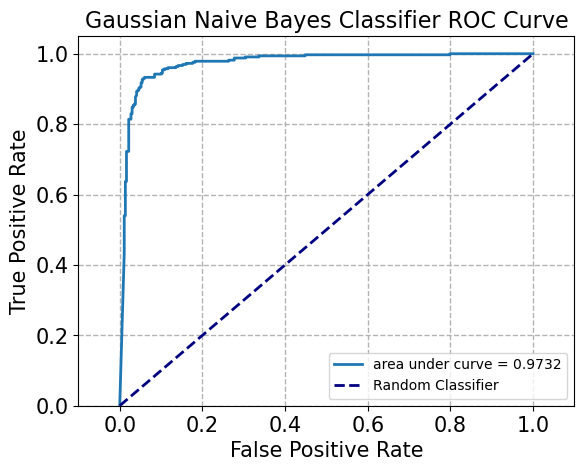

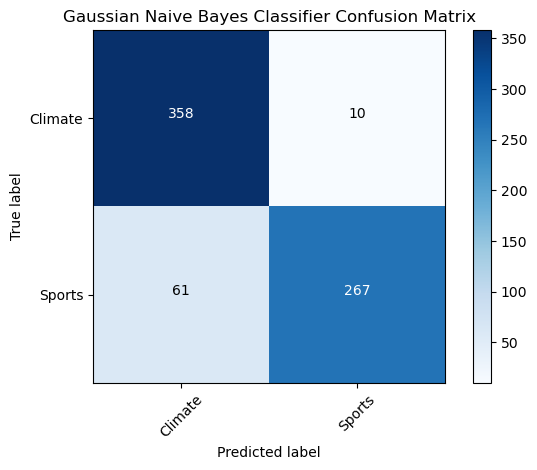

In [36]:
print("Naive Bayes Classifier")

# # ROC Curve 
fit_predict_and_plot_roc(gnb_cf, X_train_lsi, Y_train, X_test_lsi, Y_test, "Gaussian Naive Bayes Classifier")
cf_plot(Y_test, Y_test_pred_gnb, "Gaussian Naive Bayes")
statistics(Y_test, Y_test_pred_gnb)

## Question 8: Binary Classification (Pipeline)

### 8.1 Construct a Pipeline that performs feature extraction, dimensionality reduction and classification

In [37]:
from sklearn.pipeline import Pipeline

pipeline = Pipeline([
    ('vect', CountVectorizer(stop_words='english')), # vectorize (feature extraction)
    ('tfidf', TfidfTransformer()), # transformer
    ('reduce_dim', TruncatedSVD()), # dimensionality reduction
    ('clf', SVC()), # classification
])

### 8.2 The evaluation of each combination is performed with 5-fold cross-validation (use the average validation set accuracy across folds).

#### 8.2.1 In addition to any other hyperparameters you choose, your gridsearch must at least include: Loading Data, Feature Extraction, Dimensionality Reduction, Classifier, Other options. 

In [96]:
# check loading data section !!!!!!!!!
from nltk.stem import PorterStemmer

hyperparameters = [
    {
        'vect__min_df': [3,5], # Feature Extraction: min_df (3 vs 5),
        'reduce_dim': [# Dimensionality Reduction: LSI vs NMF (k = [5, 30, 80])
            TruncatedSVD(n_components=5, random_state=42),
            TruncatedSVD(n_components=30, random_state=42),
            TruncatedSVD(n_components=80, random_state=42),
            NMF(n_components=5, random_state=42, max_iter=2000),
            NMF(n_components=30, random_state=42, max_iter=2000),
            NMF(n_components=80, random_state=42, max_iter=2000)
        ], 
        'clf': [ # Classifier: SVM (best gamma), L1 Regularization, L2 Regularization, GaussianNB
            SVC(C=best_gamma, kernel='linear'), 
            LogisticRegression(C=opt_strength_lr_l1, penalty = 'l1', solver='liblinear', random_state=42),
            LogisticRegression(C=opt_strength_lr_l2, penalty = 'l2', random_state=42),
            GaussianNB(),
        ]
    }
]

# # For testing purposes 
# hyperparameters = [
#     {
#         'vect__min_df': [3,5], # Feature Extraction: min_df (3 vs 5)
#         'reduce_dim': [# Dimensionality Reduction: LSI vs NMF (k = [5, 30, 80])
#             TruncatedSVD(n_components=5, random_state=42),
#         ], 
#         'clf': [ # Classifier: SVM (best gamma), L1 Regularization, L2 Regularization, GaussianNB
#             SVC(C=best_gamma, kernel='linear'), 
#         ]
#     }
# ]

In [97]:
from sklearn.model_selection import GridSearchCV

# Create Grid 

grid_lemmatized = GridSearchCV(
    pipeline, 
    cv=5, 
    n_jobs=-1, 
    param_grid=hyperparameters, 
    scoring='accuracy'
)

grid_stemmed = GridSearchCV(
    pipeline, 
    cv=5, 
    n_jobs=-1, 
    param_grid=hyperparameters, 
    scoring='accuracy'
)

In [98]:
# Lemmatized Fit and Predict 
grid_lemmatized = grid_lemmatized.fit(train_lemmatized, Y_train)
grid_lemmatized_pred = grid_lemmatized.predict(test_lemmatized)

In [99]:
# Stem
import nltk
from nltk.stem import PorterStemmer
import re

# nltk.download()

# Stem entire data 
def stem(data):
    stemmed_data = [] 
    for text in data:
        # Return a tokenized copy of text 
        tokens = nltk.word_tokenize(text)

        # lemmatize text excluding numbers 
        stemmed_words = []
        for word in tokens:
            # print("word: " word)
            if not re.match(r'^\d+(\.\d+)?$', word): # double check this
                stemmed_word = PorterStemmer().stem(word.lower())
                stemmed_words.append(stemmed_word)
            
        stemmed_sentence = ' '.join(stemmed_words)
        
        # Add whole sentence back to the lemmatize_data array 
        stemmed_data.append(stemmed_sentence)

    return stemmed_data

In [100]:
# Stemmed data 
train_stemmed = stem(train['full_text'])
test_stemmed = stem(test['full_text'])

In [101]:
# Stemmed Fit and Predict 
grid_stemmed = grid_stemmed.fit(train_stemmed, Y_train)
grid_stemmed_pred = grid_stemmed.predict(test_stemmed)

### 8.3 What are the 5 best combinations? Report their performances on the testing set.

In [102]:
# Results for Lemmatized and Stemmed 
grid_lemmatized_result = pd.DataFrame(grid_lemmatized.cv_results_)

grid_stemmed_result = pd.DataFrame(grid_stemmed.cv_results_)

In [104]:
# Display Best Results 
grid_lemmatized_result['lemmatized'] = True
grid_stemmed_result['lemmatized'] = False
results = pd.concat([grid_lemmatized_result, grid_lemmatized_result])
results = results[['mean_test_score', 'param_clf', 'param_reduce_dim','param_vect__min_df', 'lemmatized']].sort_values(by=['mean_test_score'], ascending=False)
results = results.reset_index(drop=True)
pd.set_option('display.max_colwidth', None)
print(results.head())

,mean_test_score,param_clf,param_reduce_dim,param_vect__min_df,lemmatized
0,0.960791,"LogisticRegression(C=10, penalty='l1', random_state=42, solver='liblinear')","TruncatedSVD(n_components=80, random_state=42)",5,True
1,0.960791,"LogisticRegression(C=10, penalty='l1', random_state=42, solver='liblinear')","TruncatedSVD(n_components=80, random_state=42)",5,True
2,0.960432,"LogisticRegression(C=100, random_state=42)","TruncatedSVD(n_components=80, random_state=42)",5,True
3,0.960432,"LogisticRegression(C=100, random_state=42)","TruncatedSVD(n_components=80, random_state=42)",5,True
4,0.960072,"SVC(C=100, kernel='linear')","TruncatedSVD(n_components=80, random_state=42)",5,True
...,...,...,...,...,...
91,0.914748,GaussianNB(),"TruncatedSVD(n_components=30, random_state=42)",3,True
92,0.886691,GaussianNB(),"TruncatedSVD(n_components=5, random_state=42)",5,True
93,0.886691,GaussianNB(),"TruncatedSVD(n_components=5, random_state=42)",5,True
94,0.878058,GaussianNB(),"TruncatedSVD(n_components=5, random_state=42)",3,True


## Question 9

### 9.1.1 Perform Naive Bayes classification and multiclass SVM classification (with both One VS One and One VS the rest methods described above). 

In [38]:
# Multiclass Train and Test 
mc_train, mc_test = train_test_split(df[["full_text","leaf_label"]], test_size=0.2)

mc_train['full_text'] = mc_train['full_text'].map(clean)
mc_test['full_text'] = mc_test['full_text'].map(clean)

In [39]:
# Setting Mapping 

map_row_to_class = {0:"basketball", 1:"baseball", 2:"tennis",
3:"football", 4:"soccer", 5:"forest fire", 6:"flood",
7:"earthquake", 8:"drought", 9:"heatwave"}

reverse_row_to_class = {
    v: k for k, v in map_row_to_class.items()
}

In [40]:
# Lemmatization
mc_train_lemmatized = lemmatize(mc_train['full_text'])
mc_test_lemmatized = lemmatize(mc_test['full_text'])

In [41]:
# Count Vectorizer
mc_count_vect = CountVectorizer(min_df=3, stop_words="english")
mc_X_train_counts = mc_count_vect.fit_transform(mc_train_lemmatized).toarray()
mc_X_test_counts = mc_count_vect.transform(mc_test_lemmatized).toarray()

In [42]:
from sklearn.feature_extraction.text import TfidfTransformer

# TFIDF
mc_tfidf_transformer = TfidfTransformer()
mc_X_train_tfidf = mc_tfidf_transformer.fit_transform(mc_X_train_counts).toarray()
mc_X_test_tfidf = mc_tfidf_transformer.transform(mc_X_test_counts).toarray()

In [43]:
from sklearn.decomposition import TruncatedSVD

# LSI
mc_lsi = TruncatedSVD(n_components=50, random_state=42)
mc_X_train_lsi = mc_lsi.fit_transform(mc_X_train_tfidf)
mc_X_test_lsi = mc_lsi.transform(mc_X_test_tfidf)

In [44]:
from sklearn.decomposition import NMF

# NMF
mc_nmf = NMF(n_components=50, max_iter=2000, random_state=42)
mc_X_train_NMF = mc_nmf.fit_transform(mc_X_train_tfidf)
mc_X_test_NMF = mc_nmf.transform(mc_X_test_tfidf)

In [45]:
# Setting up Y train and test based on mapping 
mc_train['mc_label'] = mc_train['leaf_label'].apply(lambda x: reverse_row_to_class[x] if x in reverse_row_to_class else 'dumb')
mc_test['mc_label'] = mc_test['leaf_label'].apply(lambda x: reverse_row_to_class[x] if x in reverse_row_to_class else 'dumb')
mc_Y_train = mc_train['mc_label']
mc_Y_test = mc_test['mc_label']

### 9.1.2 Report the confusion matrix and calculate the accuracy, recall, precision and F-1 score of your classifiers. 

Make report generic 

In [46]:
def mc_cf_plot(Y_test, Y_pred, classifier_name): 
    # Confusion Matrix 
    cm = confusion_matrix(Y_test, Y_pred) 
    print('Confusion:\n', cm)
    plt.figure(); plot_confusion_matrix(cm, classes=map_row_to_class, title=classifier_name + ' Classifier Confusion Matrix')

def mc_statistics(Y_test, Y_pred):
    # Statistics  
    print('Accuracy:', accuracy_score(Y_test, Y_pred))
    print('Recall:', recall_score(Y_test, Y_pred, average='macro'))
    print('Precision:', precision_score(Y_test, Y_pred, average='macro', zero_division=1))
    print('F-1 Score:', f1_score(Y_test, Y_pred, average='macro')) 

In [47]:
def multiclass_report(cf, X_train, X_test, Y_train, Y_test, classifier_name): 
    Y_pred = fit_and_predict(cf, X_train, Y_train, X_test)
    mc_cf_plot(Y_test, Y_pred, classifier_name)
    mc_statistics(Y_test, Y_pred)

In [60]:
from imblearn.over_sampling import SMOTE

def multiclass_report_with_smote(cf, X_train, X_test, Y_train, Y_test, classifier_name):
    smote = SMOTE(random_state=42)
    X_train_resampled, Y_train_resampled = smote.fit_resample(X_train, Y_train) 
    Y_pred = fit_and_predict(cf, X_train_resampled, Y_train_resampled, X_test)
    mc_cf_plot(Y_test, Y_pred, classifier_name)
    mc_statistics(Y_test, Y_pred)

In [48]:
# Loop through Count Vectorizor, TFIDF, LSI, and NMF 
mc_classifiers = {
    "Count Vectorizor": [mc_X_train_counts, mc_X_test_counts], 
    "TF-IDF": [mc_X_train_tfidf, mc_X_test_tfidf], 
    "LSI": [mc_X_train_lsi, mc_X_test_lsi], 
    "NMF": [mc_X_train_NMF, mc_X_test_NMF], 
}

Linear SVC 

Count Vectorizor---------------------------
Confusion:
 [[53  0  0  1  0  0  0  0  0  0]
 [ 1 56  1  2  1  1  1  0  0  3]
 [ 1  4 55  2  1  4  2  0  0  1]
 [ 0  3  0 68  1  2  0  0  1  0]
 [ 2  3  0  1 63  2  0  0  0  0]
 [ 0  2  1  0  0  5  2  0  1 61]
 [ 0  0  0  0  0  4 69  0  0  0]
 [ 1  2  0  0  2  1  1 71  0  0]
 [ 0  1  0  0  1  7  3  0 50  3]
 [ 0  1  1  0  1 59  0  0  1  9]]
Accuracy: 0.7169540229885057
Recall: 0.7228808329392933
Precision: 0.74624839195393
F-1 Score: 0.7322651156214551
TF-IDF---------------------------
Confusion:
 [[54  0  0  0  0  0  0  0  0  0]
 [ 0 59  3  1  0  1  0  0  0  2]
 [ 0  2 60  0  1  3  1  0  0  3]
 [ 0  2  2 69  0  1  0  0  0  1]
 [ 0  3  0  1 64  0  0  0  0  3]
 [ 0  2  0  0  0  6  1  0  0 63]
 [ 0  0  0  0  0  0 71  0  0  2]
 [ 0  1  0  0  2  2  0 72  0  1]
 [ 0  1  0  0  0  5  2  0 54  3]
 [ 0  2  0  0  1 60  0  0  0  9]]
Accuracy: 0.7442528735632183
Recall: 0.7507272928691991
Precision: 0.7782566843476909
F-1 Score: 0.7630260173300933
LSI---

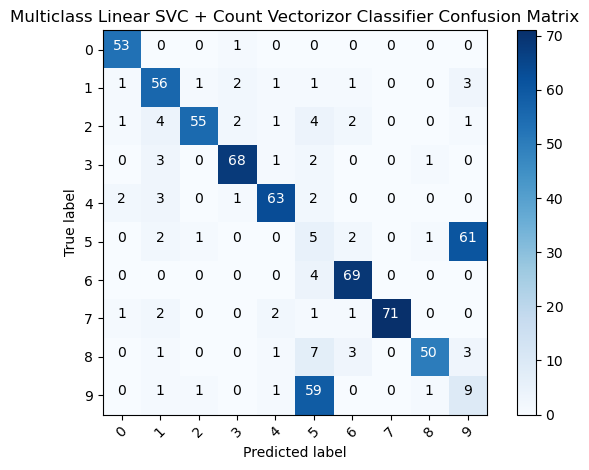

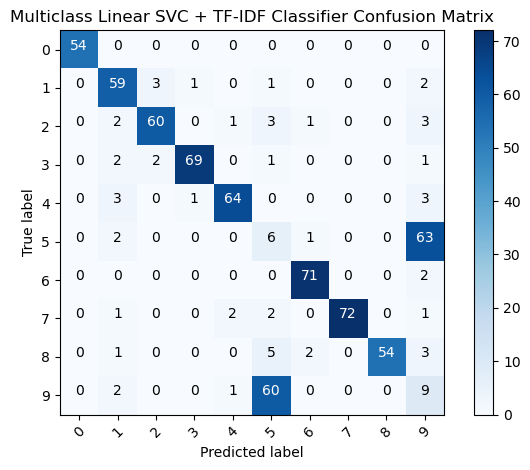

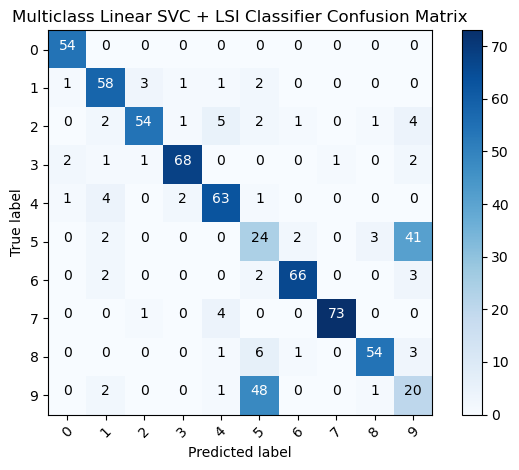

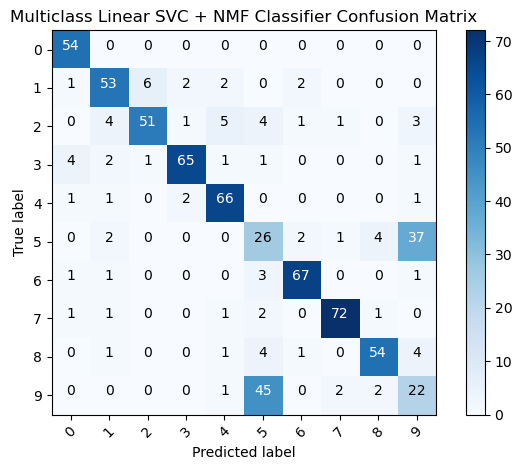

In [49]:
# Linear SVC 
mc_cf = SVC(C=100000, kernel='linear', random_state=42)
for classifier, (X_train, X_test) in mc_classifiers.items():
    print(classifier + '---------------------------')
    multiclass_report(mc_cf, X_train, X_test, mc_Y_train, mc_Y_test, "Multiclass Linear SVC + " + classifier)

Naive Bayes

Count Vectorizor---------------------------
Confusion:
 [[49  1  2  2  0  0  0  0  0  0]
 [ 1 45  8  2  1  3  0  0  1  5]
 [ 0  6 45  2  4  4  1  2  0  6]
 [ 4  4  3 50  5  4  1  0  1  3]
 [ 1  3  5  2 55  3  0  0  2  0]
 [ 0  0  0  2  0 10  1  2  1 56]
 [ 0  1  2  0  0  9 50  2  4  5]
 [ 0  0  3  0  1  2  1 64  2  5]
 [ 0  0  0  0  0 11  3  2 40  9]
 [ 0  0  0  2  2 57  1  1  1  8]]
Accuracy: 0.5977011494252874
Recall: 0.6044226228820092
Precision: 0.6605522608066468
F-1 Score: 0.629059796200129
TF-IDF---------------------------
Confusion:
 [[47  2  4  1  0  0  0  0  0  0]
 [ 0 45  8  2  1  3  0  0  0  7]
 [ 0  5 44  2  3  6  2  2  1  5]
 [ 3  3  4 51  6  4  1  0  1  2]
 [ 1  3  6  2 53  3  0  0  1  2]
 [ 0  0  0  1  1  8  1  2  2 57]
 [ 0  1  2  0  0  9 51  2  3  5]
 [ 0  1  4  0  1  4  1 61  2  4]
 [ 0  0  0  0  0  7  3  2 39 14]
 [ 0  1  0  1  2 56  1  1  2  8]]
Accuracy: 0.5847701149425287
Recall: 0.5910142495259223
Precision: 0.6554486963418871
F-1 Score: 0.6194877077388525
LSI--

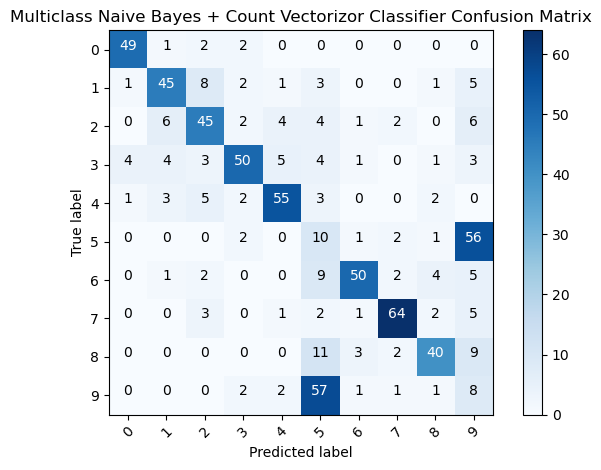

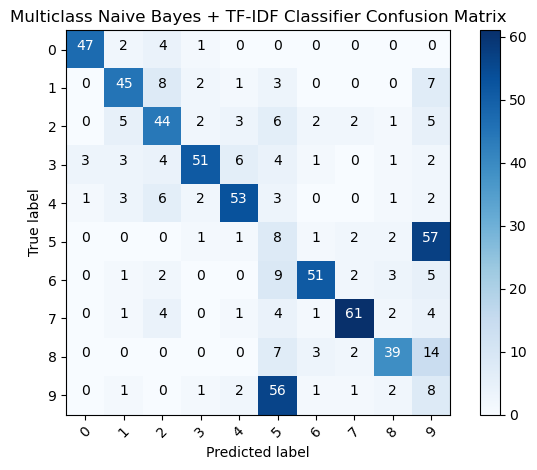

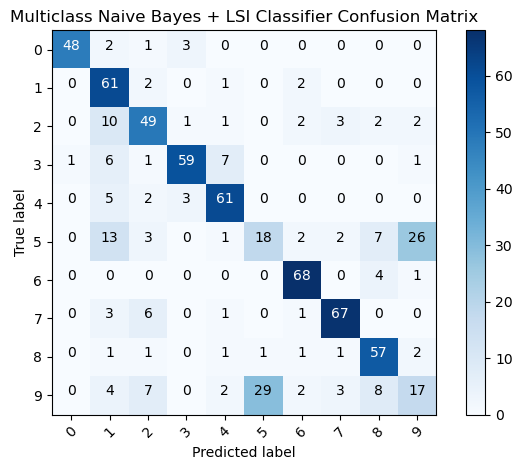

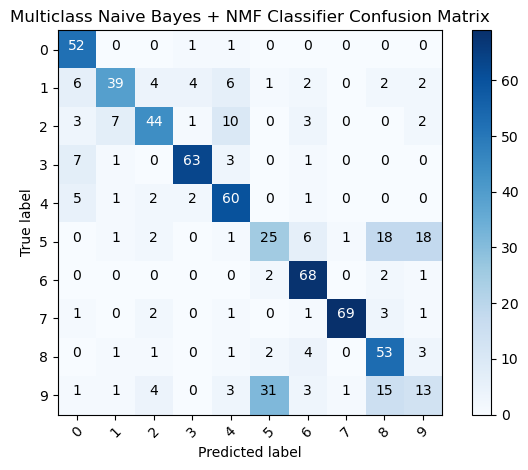

In [50]:
# Naive Bayes 
mc_cf = GaussianNB()
for classifier, (X_train, X_test) in mc_classifiers.items():
    print(classifier + '---------------------------')
    multiclass_report(mc_cf, X_train, X_test, mc_Y_train, mc_Y_test, "Multiclass Naive Bayes + " + classifier)

One VS One

Count Vectorizor---------------------------
Confusion:
 [[53  0  0  1  0  0  0  0  0  0]
 [ 1 55  1  2  2  1  1  0  0  3]
 [ 1  3 55  2  1  4  2  0  0  2]
 [ 0  3  0 68  1  2  0  0  1  0]
 [ 2  3  0  1 62  2  0  0  1  0]
 [ 0  2  1  0  0  5  2  0  1 61]
 [ 0  0  0  0  0  4 69  0  0  0]
 [ 0  2  0  0  2  0  1 72  0  1]
 [ 0  1  0  0  1  7  3  0 50  3]
 [ 0  1  1  0  1 59  0  0  1  9]]
Accuracy: 0.7155172413793104
Recall: 0.7212392820019677
Precision: 0.7452437084517995
F-1 Score: 0.7312889067670347
TF-IDF---------------------------
Confusion:
 [[54  0  0  0  0  0  0  0  0  0]
 [ 0 61  2  1  0  0  0  0  0  2]
 [ 0  2 60  0  1  2  1  0  0  4]
 [ 1  2  2 68  0  2  0  0  0  0]
 [ 0  3  0  1 64  0  0  0  0  3]
 [ 0  2  0  0  0 12  1  0  1 56]
 [ 0  0  0  0  0  3 69  0  0  1]
 [ 0  2  0  0  1  2  0 72  0  1]
 [ 0  1  0  0  0  4  2  0 56  2]
 [ 0  2  0  0  1 59  1  0  0  9]]
Accuracy: 0.7543103448275862
Recall: 0.7610947929490279
Precision: 0.7832434298202168
F-1 Score: 0.7707718020385749
LSI-

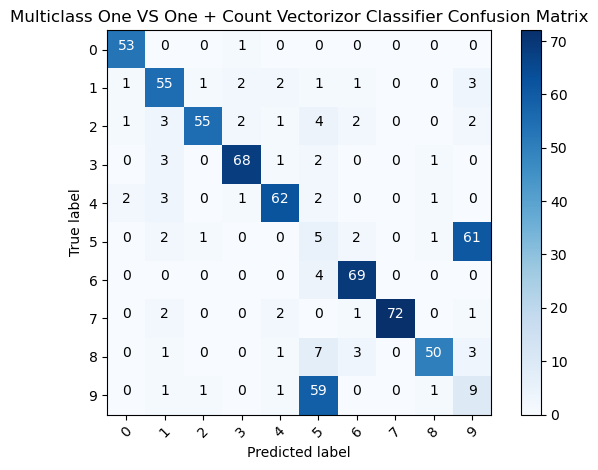

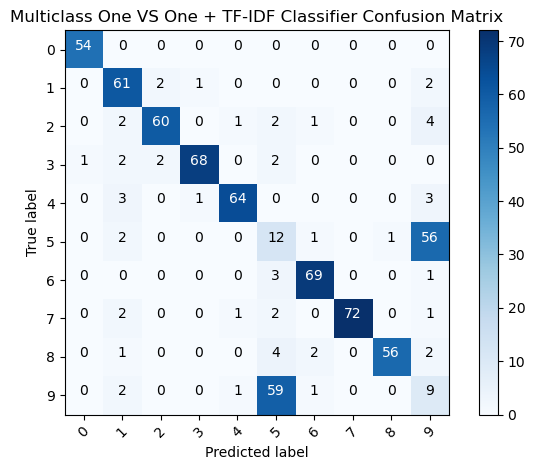

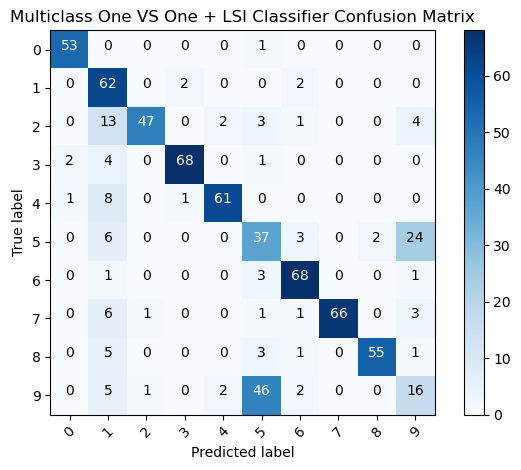

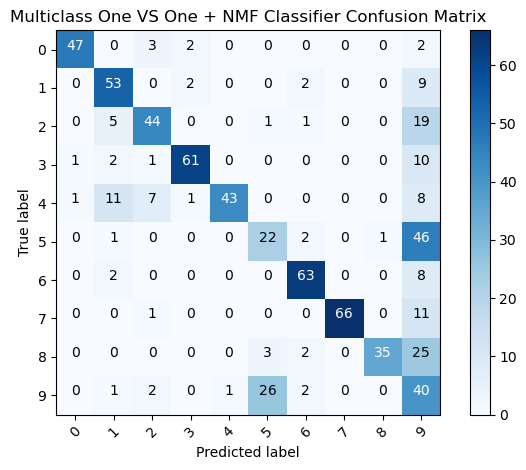

In [51]:
# One VS One 
from sklearn.multiclass import OneVsOneClassifier

mc_cf = OneVsOneClassifier(SVC(kernel='linear', random_state=42))

for classifier, (X_train, X_test) in mc_classifiers.items():
    print(classifier + '---------------------------')
    multiclass_report(mc_cf, X_train, X_test, mc_Y_train, mc_Y_test, "Multiclass One VS One + " + classifier)

One VS Rest 

Count Vectorizor---------------------------
Confusion:
 [[54  0  0  0  0  0  0  0  0  0]
 [ 1 55  2  2  1  3  1  0  0  1]
 [ 0  2 59  0  2  3  1  0  0  3]
 [ 1  0  0 71  0  2  0  0  1  0]
 [ 0  1  0  2 62  3  0  0  0  3]
 [ 0  2  1  0  0  7  2  1  0 59]
 [ 0  1  0  0  0  3 69  0  0  0]
 [ 0  0  0  0  2  2  1 70  0  3]
 [ 0  0  0  0  2  5  2  0 51  5]
 [ 0  1  1  0  1 58  0  1  0 10]]
Accuracy: 0.7298850574712644
Recall: 0.7359464452091309
Precision: 0.7681600535086537
F-1 Score: 0.7502625942625443
TF-IDF---------------------------
Confusion:
 [[54  0  0  0  0  0  0  0  0  0]
 [ 0 59  3  1  0  3  0  0  0  0]
 [ 1  1 60  1  1  1  0  2  0  3]
 [ 1  1  1 71  0  1  0  0  0  0]
 [ 0  1  0  1 67  0  0  0  0  2]
 [ 0  3  0  0  0 12  0  1  0 56]
 [ 0  1  0  0  0  2 68  2  0  0]
 [ 0  1  0  0  2  1  0 73  0  1]
 [ 0  1  0  0  0  5  2  1 53  3]
 [ 0  3  0  0  1 60  0  0  0  8]]
Accuracy: 0.7543103448275862
Recall: 0.7601977567954801
Precision: 0.7782137777093207
F-1 Score: 0.7677837955701817
LSI-

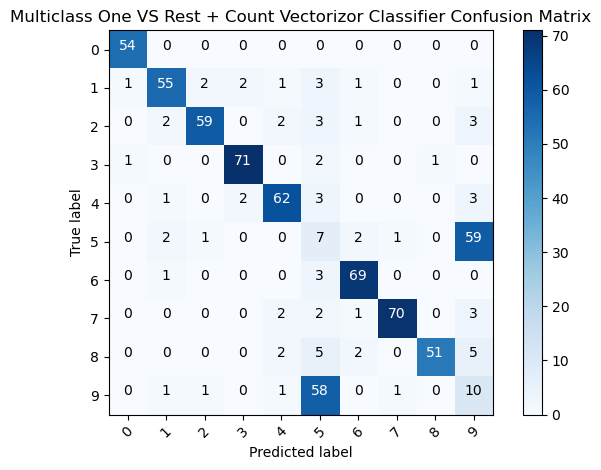

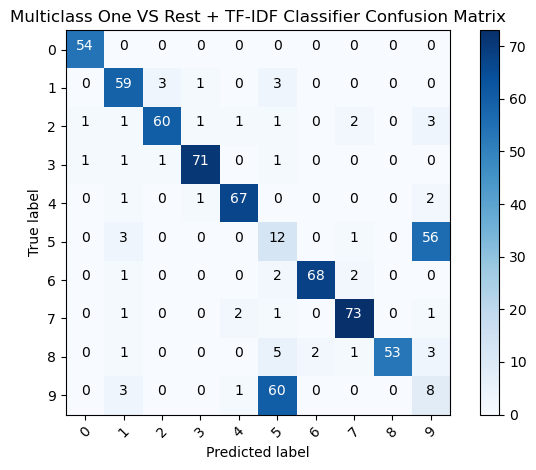

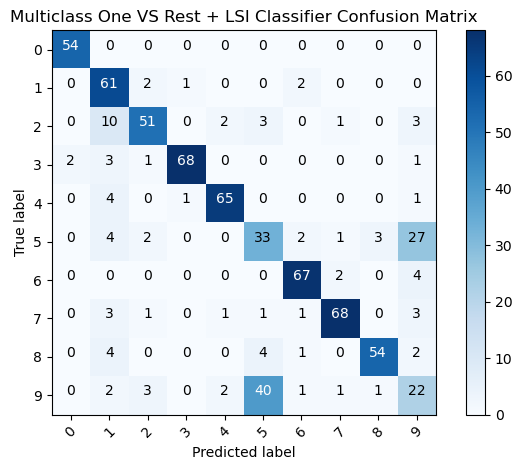

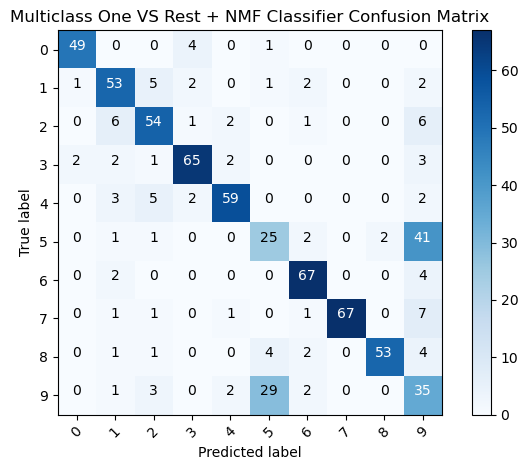

In [52]:
# One VS Rest 
from sklearn.multiclass import OneVsRestClassifier

mc_cf = OneVsRestClassifier(SVC(kernel='linear', random_state=42, class_weight="balanced"))

for classifier, (X_train, X_test) in mc_classifiers.items():
    print(classifier + '---------------------------')
    multiclass_report(mc_cf, X_train, X_test, mc_Y_train, mc_Y_test, "Multiclass One VS Rest + " + classifier)

### 9.1.3 How did you resolve the class imbalance issue in the One VS the rest model?

Adding the parameter class_weight="balanced" to the One VS Rest model allows us to resolve the class imbalance issue somewhat. 

### 9.2 Do you observe any structure in the confusion matrix? Are there distinct visible blocks on the major diagonal? What does this mean?

Do you observe any structure in the confusion matrix? 
- The higher results were along the diagonal meaning the majority of the true and predicted values were correct. 

Are there distinct visible blocks on the major diagonal? 
- Each true label would have a majority count for the predicted label. Any other issues would be regarding the label issue between 5 and 9. 

What does this mean?
- This means that the distinctive blocks were true positives and the predictions were accurate to the true labels. 

### 9.3 Based on your observation from the previous part, suggest a subset of labels that should be merged into a new larger label and recompute the accuracy and plot the confusion matrix. How did the accuracy change in One VS One and One VS the rest?

"Forest Fire" and "Heatwave" should be comebined because even when the true labels were either of them, it tended to predict hte label as the opposite. by combining the two, it increases the accuracy. 

In [53]:
# Combine 5 and 9 

map_row_to_class = {0:"basketball", 1:"baseball", 2:"tennis",
3:"football", 4:"soccer", 5:"forest fire", 6:"flood",
7:"earthquake", 8:"drought", 9: "heatwave"}

reverse_row_to_class = {
    v: k for k, v in map_row_to_class.items()
}

# Setting up Y train and test based on mapping 
mc_train['mc_label'] = mc_train['leaf_label'].apply(lambda x: reverse_row_to_class[x] if x in reverse_row_to_class else 'dumb')
mc_test['mc_label'] = mc_test['leaf_label'].apply(lambda x: reverse_row_to_class[x] if x in reverse_row_to_class else 'dumb')
# Convert instances related to both "forest fire" and "heatwave" to label 5
mc_train['mc_label'] = mc_train['mc_label'].apply(lambda x: 5 if x == 9 else x)
mc_test['mc_label'] = mc_test['mc_label'].apply(lambda x: 5 if x == 9 else x)

mc_Y_train = mc_train['mc_label']
mc_Y_test = mc_test['mc_label']

Naive Bayes

Count Vectorizor---------------------------
Confusion:
 [[ 49   1   2   2   0   0   0   0   0]
 [  1  45   7   2   1  10   0   0   0]
 [  0   6  45   2   3  11   1   2   0]
 [  4   4   3  50   5   8   1   0   0]
 [  1   3   5   2  54   4   0   0   2]
 [  0   0   0   4   2 131   2   3   2]
 [  0   1   2   0   0  15  50   2   3]
 [  0   0   3   0   1   8   1  63   2]
 [  0   0   0   0   0  24   3   2  36]]
Accuracy: 0.7514367816091954
Recall: 0.7350561077378985
Precision: 0.7883451510138747
F-1 Score: 0.7538314630033747
TF-IDF---------------------------
Confusion:
 [[ 47   2   4   1   0   0   0   0   0]
 [  0  45   8   2   1  10   0   0   0]
 [  0   5  44   2   3  11   2   2   1]
 [  3   3   3  51   5   8   1   0   1]
 [  1   3   6   2  53   5   0   0   1]
 [  0   1   0   2   3 131   2   3   2]
 [  0   1   2   0   0  15  51   2   2]
 [  0   1   4   0   1   9   1  60   2]
 [  0   0   0   0   0  23   3   2  37]]
Accuracy: 0.7456896551724138
Recall: 0.7282280835188311
Precision: 0.785984414

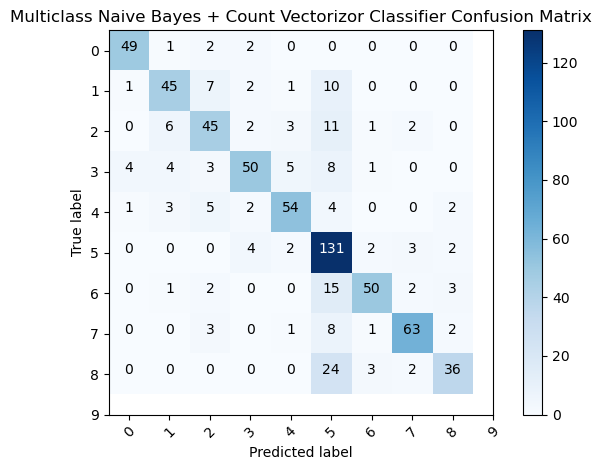

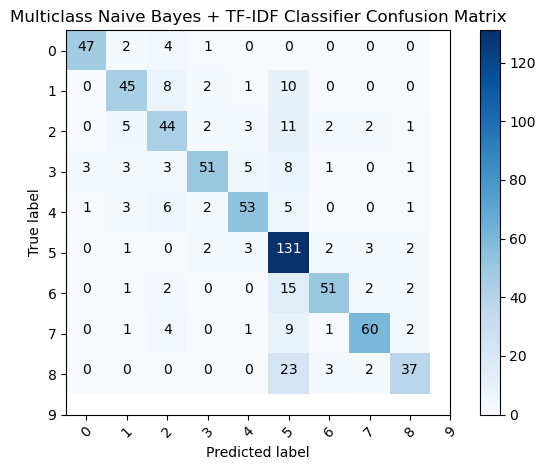

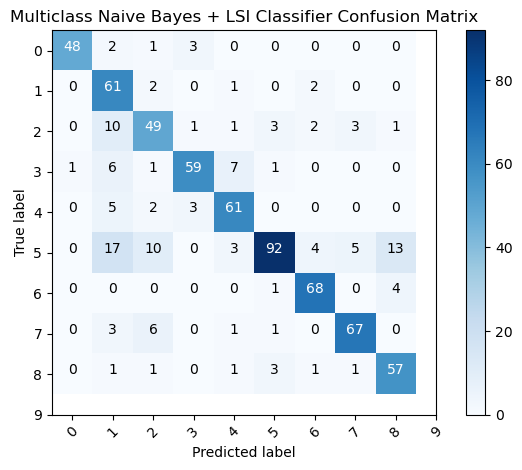

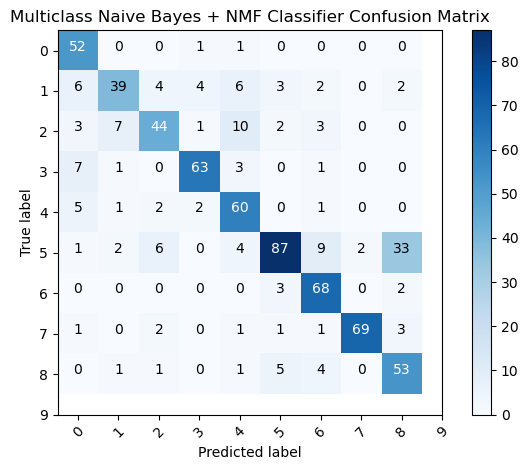

In [54]:
# Naive Bayes 
mc_cf = GaussianNB()
for classifier, (X_train, X_test) in mc_classifiers.items():
    print(classifier + '---------------------------')
    multiclass_report(mc_cf, X_train, X_test, mc_Y_train, mc_Y_test, "Multiclass Naive Bayes + " + classifier)

One VS One

Count Vectorizor---------------------------
Confusion:
 [[ 53   0   0   1   0   0   0   0   0]
 [  1  56   0   2   2   3   1   0   1]
 [  1   4  55   2   1   5   2   0   0]
 [  0   2   0  68   1   3   0   0   1]
 [  2   3   0   1  62   2   0   0   1]
 [  0   3   2   0   1 134   2   2   0]
 [  0   0   0   0   0   4  69   0   0]
 [  0   1   0   0   2   1   1  73   0]
 [  0   1   0   0   1   9   2   0  52]]
Accuracy: 0.8936781609195402
Recall: 0.8896939099857831
Precision: 0.9051733286973561
F-1 Score: 0.8951571064709837
TF-IDF---------------------------
Confusion:
 [[ 54   0   0   0   0   0   0   0   0]
 [  0  60   2   1   0   3   0   0   0]
 [  0   2  60   0   1   6   1   0   0]
 [  1   0   1  68   0   5   0   0   0]
 [  0   2   0   1  64   4   0   0   0]
 [  0   4   0   0   1 136   2   0   1]
 [  0   0   0   0   0   4  69   0   0]
 [  0   2   0   0   1   3   0  72   0]
 [  0   1   0   0   0   9   2   0  53]]
Accuracy: 0.9137931034482759
Recall: 0.9113800384402997
Precision: 0.935537324

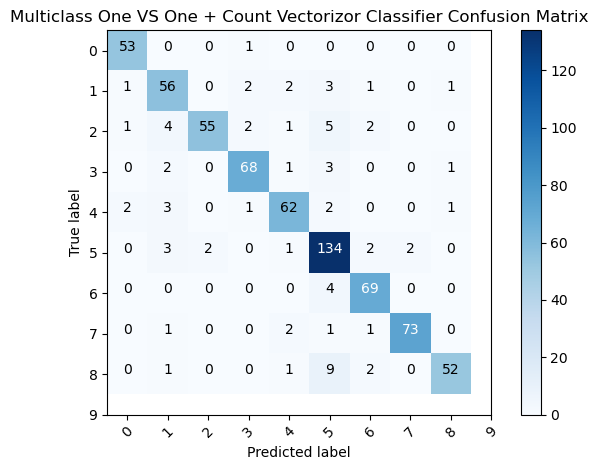

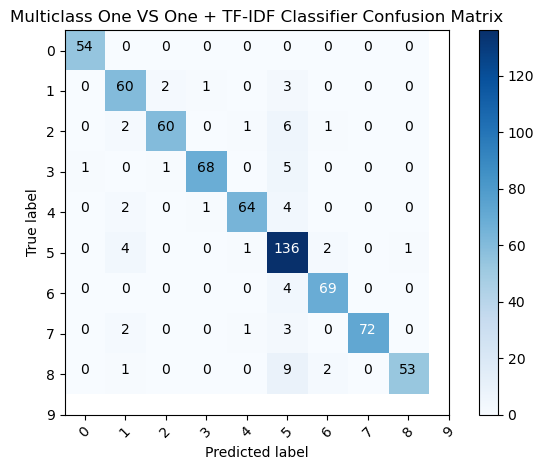

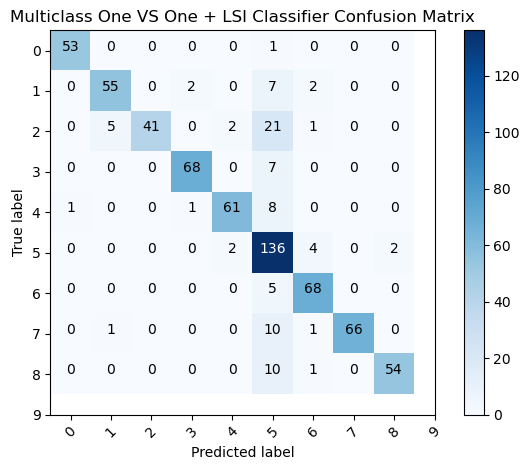

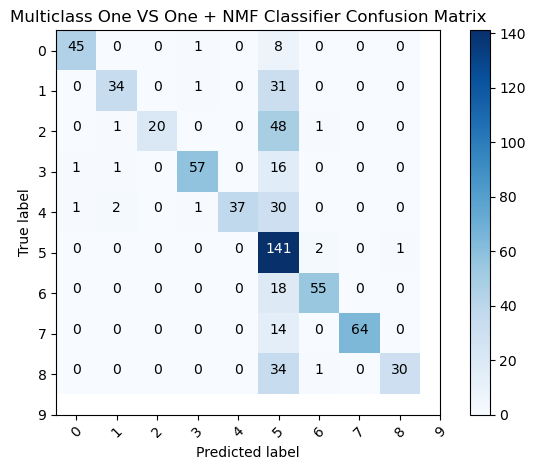

In [55]:
# One VS One 
from sklearn.svm import SVC
from sklearn.multiclass import OneVsOneClassifier

mc_cf = OneVsOneClassifier(SVC(kernel='linear', random_state=42))

for classifier, (X_train, X_test) in mc_classifiers.items():
    print(classifier + '---------------------------')
    multiclass_report(mc_cf, X_train, X_test, mc_Y_train, mc_Y_test, "Multiclass One VS One + " + classifier)

One VS Rest 

Count Vectorizor---------------------------
Confusion:
 [[ 53   0   0   1   0   0   0   0   0]
 [  2  54   1   1   1   5   1   0   1]
 [  0   2  60   0   1   6   1   0   0]
 [  1   0   0  71   0   2   0   0   1]
 [  0   2   0   2  63   4   0   0   0]
 [  0   3   1   0   1 134   1   4   0]
 [  0   0   0   0   0   1  72   0   0]
 [  0   1   0   0   2   4   1  70   0]
 [  0   0   0   0   1   9   2   0  53]]
Accuracy: 0.9051724137931034
Recall: 0.9022749117082086
Precision: 0.9210698709506562
F-1 Score: 0.9098318004744207
TF-IDF---------------------------
Confusion:
 [[ 54   0   0   0   0   0   0   0   0]
 [  0  58   4   1   0   3   0   0   0]
 [  0   1  60   1   1   7   0   0   0]
 [  2   0   1  69   0   2   0   0   1]
 [  0   0   0   0  69   2   0   0   0]
 [  0   0   0   1   3 138   1   0   1]
 [  0   0   0   2   0   2  69   0   0]
 [  0   1   0   0   2   2   0  73   0]
 [  0   0   0   0   0  10   1   0  54]]
Accuracy: 0.9252873563218391
Recall: 0.9219963556998094
Precision: 0.941544859

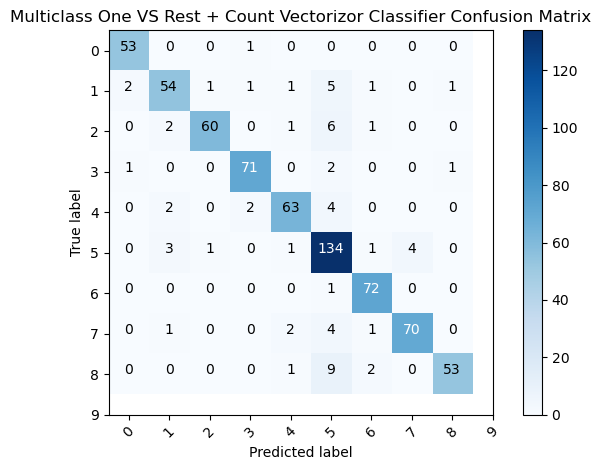

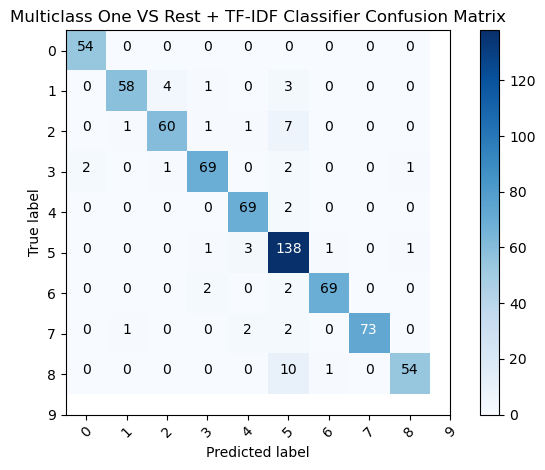

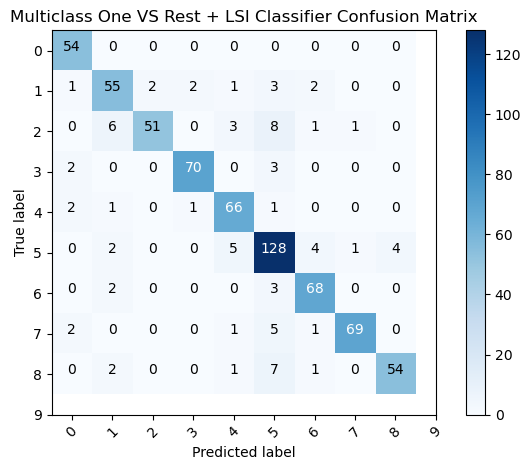

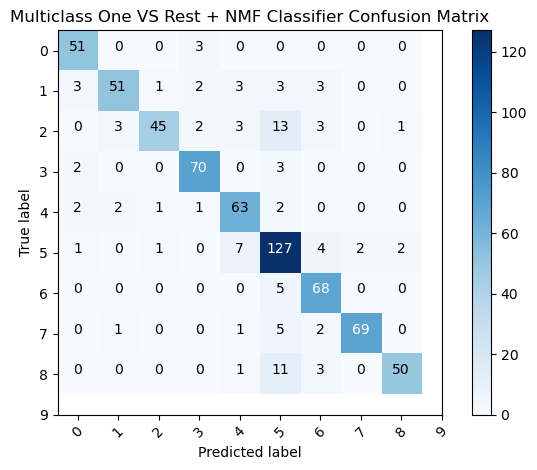

In [56]:
# One VS Rest 
from sklearn.multiclass import OneVsRestClassifier

mc_cf = OneVsRestClassifier(SVC(kernel='linear', random_state=42))

for classifier, (X_train, X_test) in mc_classifiers.items():
    print(classifier + '---------------------------')
    multiclass_report(mc_cf, X_train, X_test, mc_Y_train, mc_Y_test, "Multiclass One VS Rest + " + classifier)

### 9.4 Does class imbalance impact the performance of the classification once some classes are merged? Provide a resolution for the class imbalance and recompute the accuracy and plot the confusion matrix in One VS One and One VS the rest?

Does class imbalance impact the performance of the classification once some classes are merged? 
- answer 

Count Vectorizor---------------------------
Confusion:
 [[ 52   0   0   0   0   0   0   0   2]
 [  2  45   1   2   7   8   0   0   1]
 [  0   1  46   3   5   9   4   1   1]
 [  5   4   0  63   1   1   1   0   0]
 [  2   3   0   0  60   4   1   0   1]
 [  0   2   0   0   1 140   1   0   0]
 [  0   0   0   0   0   4  68   0   1]
 [  1   0   0   0   1  10   1  65   0]
 [  0   1   0   0   0  11   3   0  50]]
Accuracy: 0.8462643678160919
Recall: 0.8325875109511784
Precision: 0.8705114801624654
F-1 Score: 0.8437222743177109
TF-IDF---------------------------
Confusion:
 [[ 54   0   0   0   0   0   0   0   0]
 [  0  60   2   1   0   3   0   0   0]
 [  0   3  61   0   1   5   0   0   0]
 [  1   2   2  68   0   2   0   0   0]
 [  0   2   0   1  64   4   0   0   0]
 [  0   5   0   0   1 136   1   0   1]
 [  0   2   0   0   0   4  67   0   0]
 [  0   2   0   0   1   3   0  72   0]
 [  0   1   0   0   0   7   2   0  55]]
Accuracy: 0.9152298850574713
Recall: 0.9133420034159632
Precision: 0.932745217

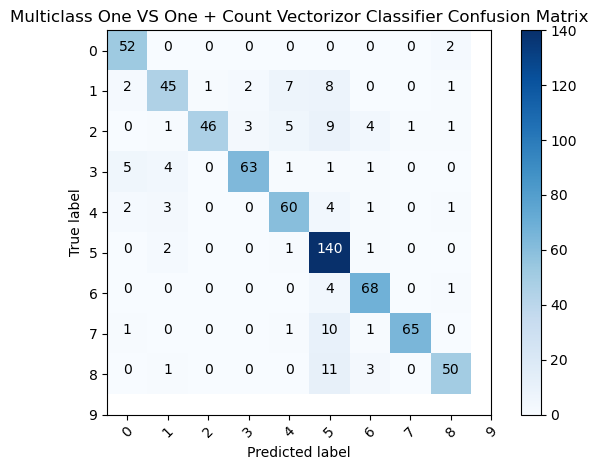

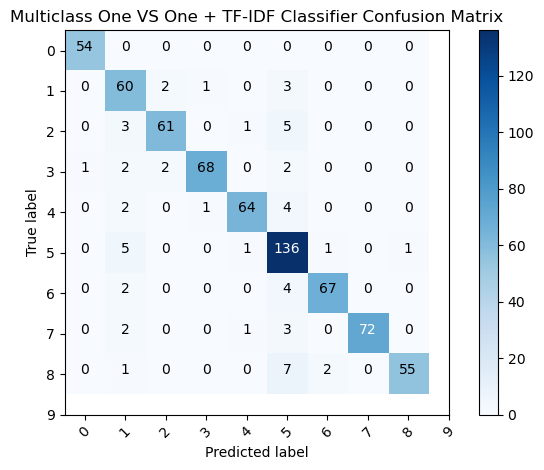

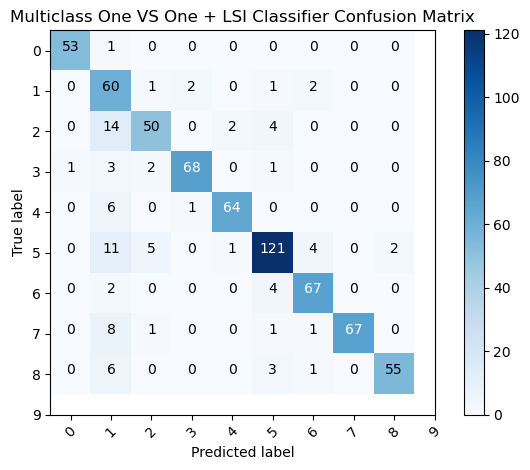

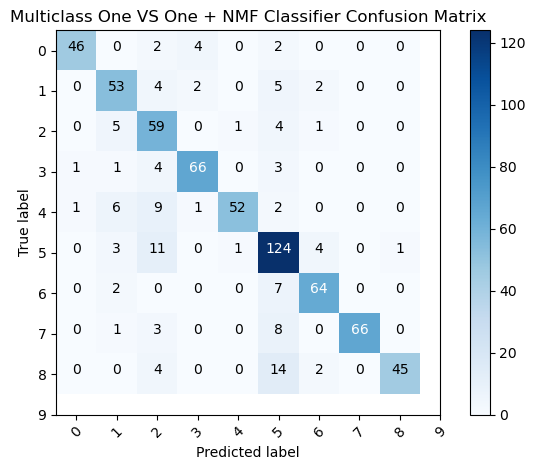

In [61]:
# One VS One 
from sklearn.svm import SVC
from sklearn.multiclass import OneVsOneClassifier

mc_cf = OneVsOneClassifier(SVC(kernel='linear', random_state=42))

for classifier, (X_train, X_test) in mc_classifiers.items():
    print(classifier + '---------------------------')
    multiclass_report_with_smote(mc_cf, X_train, X_test, mc_Y_train, mc_Y_test, "Multiclass One VS One + " + classifier)

Count Vectorizor---------------------------
Confusion:
 [[ 52   1   0   1   0   0   0   0   0]
 [  1  50   2   2   2   5   0   2   2]
 [  1   1  52   1   2   7   2   4   0]
 [  3   2   1  66   1   1   0   0   1]
 [  2   4   0   1  60   2   0   1   1]
 [  0   4   2   0   1 135   1   1   0]
 [  0   0   0   1   0   2  70   0   0]
 [  1   0   0   1   3   5   0  68   0]
 [  0   1   0   0   1   8   3   1  51]]
Accuracy: 0.867816091954023
Recall: 0.8601422946589302
Precision: 0.8759416298229082
F-1 Score: 0.8655701041911491
TF-IDF---------------------------
Confusion:
 [[ 54   0   0   0   0   0   0   0   0]
 [  0  60   3   1   0   2   0   0   0]
 [  0   2  61   0   1   5   0   0   1]
 [  2   0   2  70   0   1   0   0   0]
 [  0   0   1   1  68   1   0   0   0]
 [  0   0   0   2   1 134   1   2   4]
 [  0   0   0   1   1   0  69   0   2]
 [  0   1   1   0   2   1   0  73   0]
 [  0   2   0   1   0   6   2   0  54]]
Accuracy: 0.9238505747126436
Recall: 0.9237807771555924
Precision: 0.9274696492

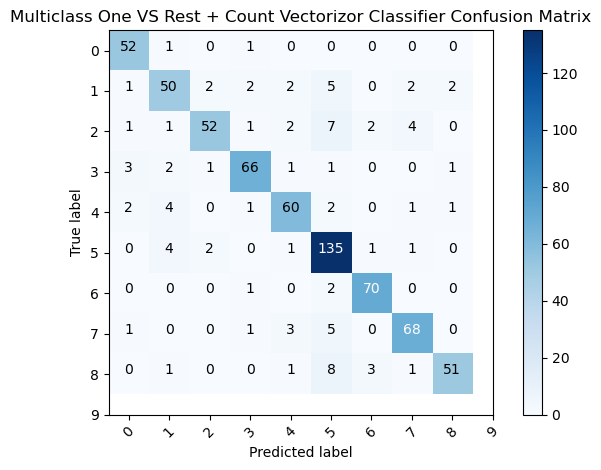

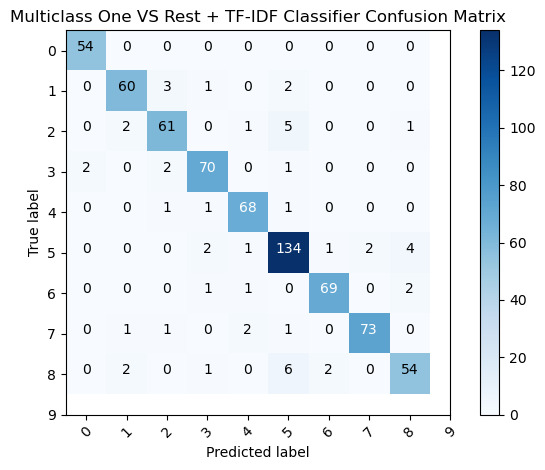

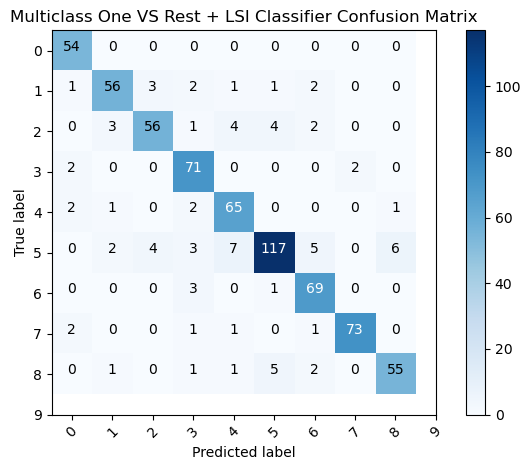

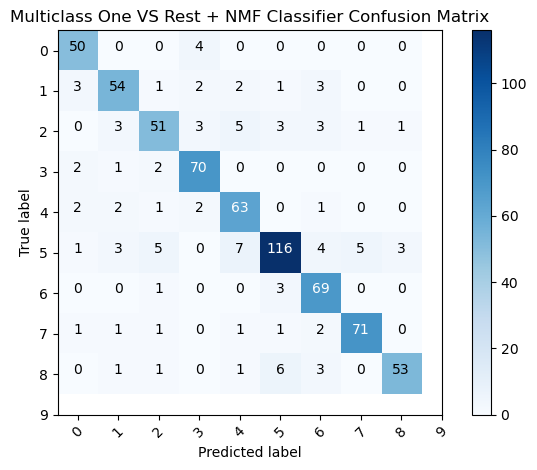

In [62]:
# One VS Rest 
from sklearn.multiclass import OneVsRestClassifier

mc_cf = OneVsRestClassifier(SVC(kernel='linear', random_state=42))

for classifier, (X_train, X_test) in mc_classifiers.items():
    print(classifier + '---------------------------')
    multiclass_report_with_smote(mc_cf, X_train, X_test, mc_Y_train, mc_Y_test, "Multiclass One VS Rest + " + classifier)

## Question 10 

### a) Why are GLoVE embeddings trained on the ratio of co-occurrence probabilities rather than the probabilities themselves?
- GLoVE embeddings are trained on the ratio of co-occurance of probabilities as they aim to capture each word as uniquely as possible. The ratio also helps in removing the influence of some common words like 'a' and 'is' which helps the glove embeddings to capture lesser seen relationships that are more informative in real world.

### b) In the two sentences: “James is running in the park.” and “James is running for the presidency.”, would GLoVE embeddings return the same vector for the word running in both cases? Why or why not?
- GLoVE embeddings would return the same vector in both cases as the GLoVE embedding vectors are pre-trained static vectors. These pre-trained vectors are obtained after training on a large dataset so the capture all the information related to one word in the static vectors that we use. 

### c) What do you expect for the values given. 
- $||GLoVE['woman'] - GLoVE['man']||_2$ $||GLoVE['wife'] - GLoVE['husband']||_2$ $||GLoVE['wife'] - GLoVE['orange']||_2$

The given l2 norm between the GLoVE embedding vectors of "woman" and "man" is expected to be small as the probability that the two words "woman" and "man" occuring together is higher than the probability of words "wife" and "orange". Whereas, the l2 norm of "wife" and "husband" and "woman" and "man" will not be very differnt.

Conclusion: The l2 norm of "woman" and "man" will be close to the l2 norm of "wife" and "husband" and will be a smaller value. Whereas, the l2 norm of "wife" and "orange" will be a larger value and this value will be vary a lot as compared to the other values. 

### d) Given a word, would you rather stem or lemmatize the word before mapping it to its GLoVE embedding?
- We would lemmatize the word before mapping it to its GLoVE embedding and not stem it as, lemmatization keeps the meaning of the word intact by just recuding the word to it's corresponding stem value. Wheareas, stemming does not consider the meaning it just removes the prefix or suffix attached to the word, the resulting word after stemming need not necessarily make sense or have a meaning.
As the GLoVe embeddings are vectors available for actual words we can use lemmatization. 

## Question 11

### a) For the binary classification task distinguishing the “sports” class and “climate” class. Describe a feature engineering process that uses GLoVE word embeddings to represent each document.


The feature engineering process that we used is as follows:
1) We use the keywords column given in the data. 
2) We then find the glove embedding for each keyword of a data point. 
3) We normalize and get a vector representation of 300 for each data point. We will then use this representation to perform classification. 

Got an accuracy of 0.9353448275862069

### b) Select a classifier model, train and evaluate it with your GLoVE-based feature. If you are doing any cross-validation, please make sure to use a limited set of options so that your code finishes running in a reasonable amount of time.

In [64]:
import numpy as np

# Function to load the GloVe Embeddings
def load_glove_embeddings(file):
    embeddings_dict = {}
    dimension_of_glove = 300
    with open(file, 'r', encoding="utf-8") as f:
        for line in f:
            values = line.split()
            word = values[0]
            vector = np.asarray(values[1:], "float32")
            embeddings_dict[word] = vector
#             print(f"embeddings_dict[word], word:{embeddings_dict[word], word}")
    return embeddings_dict

# word_embeddings is a dictionary that contains words as keys
word_embeddings = load_glove_embeddings("glove.6B.300d.txt")

In [65]:
vector_for_example = word_embeddings['conceiving']
dimensionality = len(vector_for_example)
print(f"The dimensionality of the GloVe vectors is: {dimensionality}")


The dimensionality of the GloVe vectors is: 300


In [66]:

import pandas as pd

from sklearn.model_selection import train_test_split

df = pd.read_csv('Project1-ClassificationDataset.csv')
x_train, x_test, y_train, y_test = train_test_split(df['keywords'],df['root_label'], test_size=0.2)



In [69]:
import ast  
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

glove_embeddings = word_embeddings 

def document_embeddings(document, glove_embeddings):
    
    word_embeddings = []    
    words = ast.literal_eval(document)
    # print(f"words{type(words)}")
    
    for word in words:
        # print(f"word: {word}")
        if word in glove_embeddings:
            word_embeddings.append(glove_embeddings[word])
    
    # average word embeddings
    avg_embedding = np.mean(normalize(word_embeddings), axis=0)
    # print(f"len:{len(avg_embedding)}")
    return avg_embedding

# Generate document embeddings for all documents
X_train_embeddings = np.array([document_embeddings(doc, glove_embeddings) for doc in x_train])
X_test_embeddings = np.array([document_embeddings(doc, glove_embeddings) for doc in x_test])
print(f"X_train_embeddings: {len(X_train_embeddings)}")


# classifier used: Logistic Regression
classifier = LogisticRegression()
classifier.fit(X_train_embeddings, y_train)
y_pred = classifier.predict(X_test_embeddings)

# Accuracy of the Model  
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)


X_train_embeddings: 2780
Accuracy: 0.9353448275862069


## Question 12
### Plot the relationship between the dimension of the pre-trained GLoVE embedding and the resulting accuracy of the model in the classification task. Describe the observed trend. Is this trend expected? Why or why not?

The trend shows that as the dimensions of the pre-trained GLoVE embeddings increases we get better accuracy. Thus the accuracy increses as the dimisions increase.   
Yes, this is the expected trend. This is because as the dimesions increases there is more information captured per word, which could improve the classification task. 

In [75]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

def train_and_evaluate(X_train, X_test, y_train, y_test):
    classifier = LogisticRegression()
    classifier.fit(X_train, y_train)
    y_pred = classifier.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(f"accuracy:{accuracy}")
    return accuracy

# Differnt GLoVE embeddings files
embedding_files = ['glove.6B.50d.txt', 'glove.6B.100d.txt', 'glove.6B.200d.txt', 'glove.6B.300d.txt']

X_train, X_test, y_train, y_test = train_test_split(df['keywords'],df['root_label'], test_size=0.2)

accuracies = []
embedding_dimensions = []
i = 0

for file in embedding_files:
    
    embeddings = load_glove_embeddings(file)
    
    # Generate document embeddings for training and testing data
    X_train_embeddings = np.array([document_embeddings(doc, embeddings) for doc in X_train])
    X_test_embeddings = np.array([document_embeddings(doc, embeddings) for doc in X_test])
    print(f"X_train_embeddings: {len(X_train_embeddings[0])}")
    
    # Train and evaluate classifier
    accuracy = train_and_evaluate(X_train_embeddings, X_test_embeddings, y_train, y_test)
    accuracies.append(accuracy)
    
    embedding_dim = i
    i += 1
    embedding_dimensions.append(embedding_dim)
    
    print(f"Embedding Dimension: {embedding_dim}, Accuracy: {accuracy}")



X_train_embeddings: 50
accuracy:0.9295977011494253
Embedding Dimension: 0, Accuracy: 0.9295977011494253
X_train_embeddings: 100
accuracy:0.9339080459770115
Embedding Dimension: 1, Accuracy: 0.9339080459770115
X_train_embeddings: 200
accuracy:0.9353448275862069
Embedding Dimension: 2, Accuracy: 0.9353448275862069
X_train_embeddings: 300
accuracy:0.9396551724137931
Embedding Dimension: 3, Accuracy: 0.9396551724137931


## Question 13
### Compare and contrast the two visualizations. Are there clusters formed in either or both of the plots? We will pursue the clustering aspect further in the next project.

In the 2-D visualization for GLoVE-based embeddings we can see that the two classes seened to be forming clusters. Points that belong to the same class are closer to eachother, this shows that the GLoVE-based embeddings bring similar classes closer to form clusters. Whereas, we can see that the 2-D representation of the normalized random vectors shows the data points scattered all around the two dimensnsional space. 

In [80]:
! pip install umap-learn
! pip install pandas matplotlib datashader bokeh holoviews scikit-image colorcet

import umap
import umap.plot
import numpy as np

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 38.1 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 37.7 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.3/4.3 MB 38.6 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.9/13.9 MB 41.4 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 31.8 MB/s eta 0:00:0000:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 28.2 MB/s eta 0:00:0000:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 26.9 MB/s eta 0:00:00:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.1/56.1 kB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 113.6/113.6 kB 4.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 kB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.8/82.8 kB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.8/20.8 MB 36.9 MB

/Users/vaniagrawal/anaconda3/lib/python3.10/site-packages/umap/plot.py:203: NumbaDeprecationWarning: The keyword argument 'nopython=False' was supplied. From Numba 0.59.0 the default is being changed to True and use of 'nopython=False' will raise a warning as the argument will have no effect. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit(nopython=False)


In [81]:
X_train_embeddings = np.array([document_embeddings(doc, word_embeddings) for doc in x_train])
X_test_embeddings = np.array([document_embeddings(doc, word_embeddings) for doc in x_test])

glove_embedding_2d = umap.UMAP(n_components=2, metric='euclidean').fit(X_train_embeddings)

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


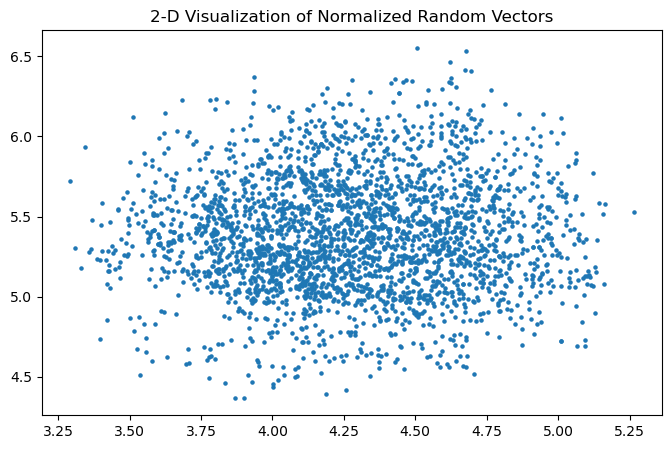

In [82]:
# for normalized random vectors
import matplotlib.pyplot as plt
random_vectors = np.random.normal(0, 1, (2780, 300))


random_vectors_norm = random_vectors / np.linalg.norm(random_vectors, axis=1)[:, np.newaxis]


umap_reducer = umap.UMAP(n_components=10, metric='euclidean')
umap_embeddings = umap_reducer.fit_transform(random_vectors_norm)


plt.figure(figsize=(8, 5))
plt.scatter(umap_embeddings[:, 0], umap_embeddings[:, 1], s=5)
plt.title('2-D Visualization of Normalized Random Vectors')
plt.show()

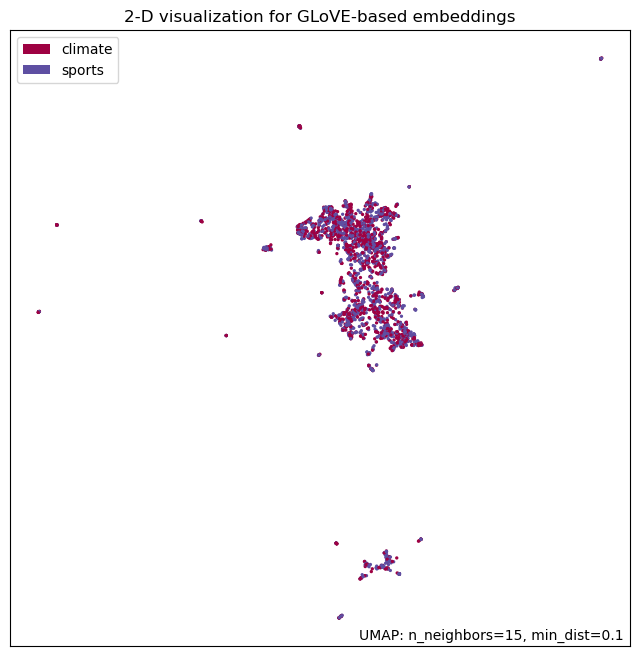

<Figure size 500x500 with 0 Axes>

In [84]:

glove = umap.plot.points(glove_embedding_2d,labels=np.array(y_train))
plt.title('2-D visualization for GLoVE-based embeddings')
plt.figure(figsize=(5, 5))
plt.show()